<a href="https://colab.research.google.com/github/OJB-Quantum/Notebooks/blob/main/Calibrating_Qubits_Pulse_(State_Classification_%26_More).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Calibrating qubits using Qiskit Pulse

Qiskit is an open-source framework for programming quantum computers (Ref. [1](#refs)). 

Qiskit Pulse provides a language for specifying pulse level control (i.e. control of the continuous time dynamics of input signals) of a general quantum device independent of the specific hardware implementation (Ref. [2](#refs)). 



## Contents

1. [Getting Started](#importing)
2. [Finding the qubit Frequency using a Frequency Sweep](#frequencysweep)
3. [Calibrating and using a $\pi$ Pulse](#calib)    
  3.1 [Calibrating $\pi$ Pulses using a Rabi Experiment](#rabi)    
  3.2 [Determining 0 vs 1](#zerovone)    
  3.3 [Measuring $T_1$ using Inversion Recovery](#T1)    
4. [Determining qubit Coherence](#det_co)    
  4.1 [Measuring the qubit Frequency Precisely using a Ramsey Experiment](#ramsey)    
  4.2 [Measuring $T_2$ using Hahn Echoes](#hahn)    
5. [References](#refs)

In [ ]:
import warnings
warnings.filterwarnings('ignore')
from qiskit.tools.jupyter import *

In [ ]:
from qiskit import IBMQ
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-research-2', group='uni-minnesotta-tw-1', project='main')
backend = provider.get_backend('ibm_perth')

In [ ]:
backend_config = backend.configuration()

In [ ]:
dt = backend_config.dt
print(f"Sampling time: {dt*1e9} ns")    # The configuration returns dt in seconds, so multiply by
                                        # 1e9 to get nanoseconds

Sampling time: 0.2222222222222222 ns


In [ ]:
backend.configuration().timing_constraints

{'acquire_alignment': 16,
 'granularity': 16,
 'min_length': 64,
 'pulse_alignment': 16}

In [ ]:
acquire_alignment = backend.configuration().timing_constraints['acquire_alignment']
granularity = backend.configuration().timing_constraints['granularity']
pulse_alignment = backend.configuration().timing_constraints['pulse_alignment']

In [ ]:
import numpy as np

lcm = np.lcm(acquire_alignment, pulse_alignment)
print(f"Least common multiple of acquire_alignment and pulse_alignment: {lcm}")

Least common multiple of acquire_alignment and pulse_alignment: 16


In [ ]:
backend_defaults = backend.defaults()

In [ ]:
# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc.)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

# We will find the qubit frequency for the following qubit.
qubit = 0

# The sweep will be centered around the estimated qubit frequency.
center_frequency_Hz = backend_defaults.qubit_freq_est[qubit]        # The default frequency is given in Hz
                                                                    # warning: this will change in a future release
print(f"Qubit {qubit} has an estimated frequency of {center_frequency_Hz / GHz} GHz.")

# scale factor to remove factors of 10 from the data
scale_factor = 1e-7

# We will sweep 40 MHz around the estimated frequency
frequency_span_Hz = 40 * MHz
# in steps of 1 MHz.
frequency_step_Hz = 1 * MHz

# We will sweep 20 MHz above and 20 MHz below the estimated frequency
frequency_min = center_frequency_Hz - frequency_span_Hz / 2
frequency_max = center_frequency_Hz + frequency_span_Hz / 2
# Construct an np array of the frequencies for our experiment
frequencies_GHz = np.arange(frequency_min / GHz, 
                            frequency_max / GHz, 
                            frequency_step_Hz / GHz)

print(f"The sweep will go from {frequency_min / GHz} GHz to {frequency_max / GHz} GHz \
in steps of {frequency_step_Hz / MHz} MHz.")

Qubit 0 has an estimated frequency of 5.15754446587089 GHz.
The sweep will go from 5.1375444658708895 GHz to 5.17754446587089 GHz in steps of 1.0 MHz.


In [ ]:
def get_closest_multiple_of(vaule, base_number):
    return int(vaule + base_number/2) - (int(vaule + base_number/2) % base_number)

In [ ]:
# samples need to be multiples of 16
def get_closest_multiple_of_16(num):
    return get_closest_multiple_of(num, granularity)

In [ ]:
# Convert seconds to dt
def get_dt_from(sec):
    return get_closest_multiple_of(sec/dt, lcm)

In [ ]:
from qiskit import pulse                  # This is where we access all of our Pulse features!
from qiskit.circuit import Parameter      # This is Parameter Class for variable parameters.
from qiskit.circuit import QuantumCircuit, Gate

# Drive pulse parameters (us = microseconds)
drive_sigma_sec = 0.015 * us                           # This determines the actual width of the gaussian
drive_duration_sec = drive_sigma_sec * 8                # This is a truncating parameter, because gaussians don't have 
                                                        # a natural finite length
drive_amp = 0.05

# Create the base schedule
# Start with drive pulse acting on the drive channel
freq = Parameter('freq')
with pulse.build(backend=backend, default_alignment='sequential', name='Frequency sweep') as sweep_sched:
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(freq, drive_chan)
    # Drive pulse samples
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              sigma=drive_sigma,
                              amp=drive_amp,
                              name='freq_sweep_excitation_pulse'), drive_chan)

In [ ]:
sweep_gate = Gate("sweep", 1, [freq])

qc_sweep = QuantumCircuit(1, 1)

qc_sweep.append(sweep_gate, [0])
qc_sweep.measure(0, 0)
qc_sweep.add_calibration(sweep_gate, (0,), sweep_sched, [freq])

# Create the frequency settings for the sweep (MUST BE IN HZ)
frequencies_Hz = frequencies_GHz*GHz
exp_sweep_circs = [qc_sweep.assign_parameters({freq: f}, inplace=False) for f in frequencies_Hz]

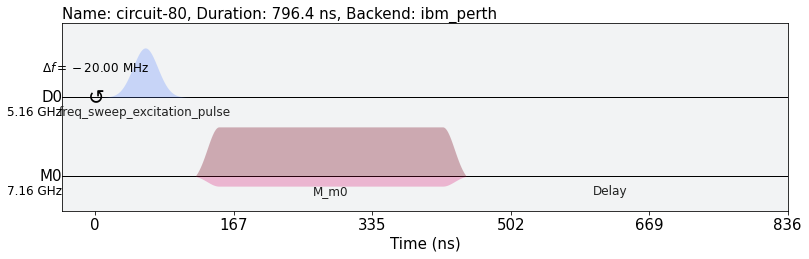

In [ ]:
from qiskit import schedule

sweep_schedule = schedule(exp_sweep_circs[0], backend)
sweep_schedule.draw(backend=backend)

In [ ]:
num_shots_per_frequency = 3000

job = backend.run(exp_sweep_circs, 
                  meas_level=1, 
                  meas_return='avg', 
                  shots=num_shots_per_frequency)

In [ ]:
from qiskit.tools.monitor import job_monitor
job_monitor(job)

Job Status: job has successfully run


In [ ]:
frequency_sweep_results = job.result(timeout=120) # timeout parameter set to 120 seconds

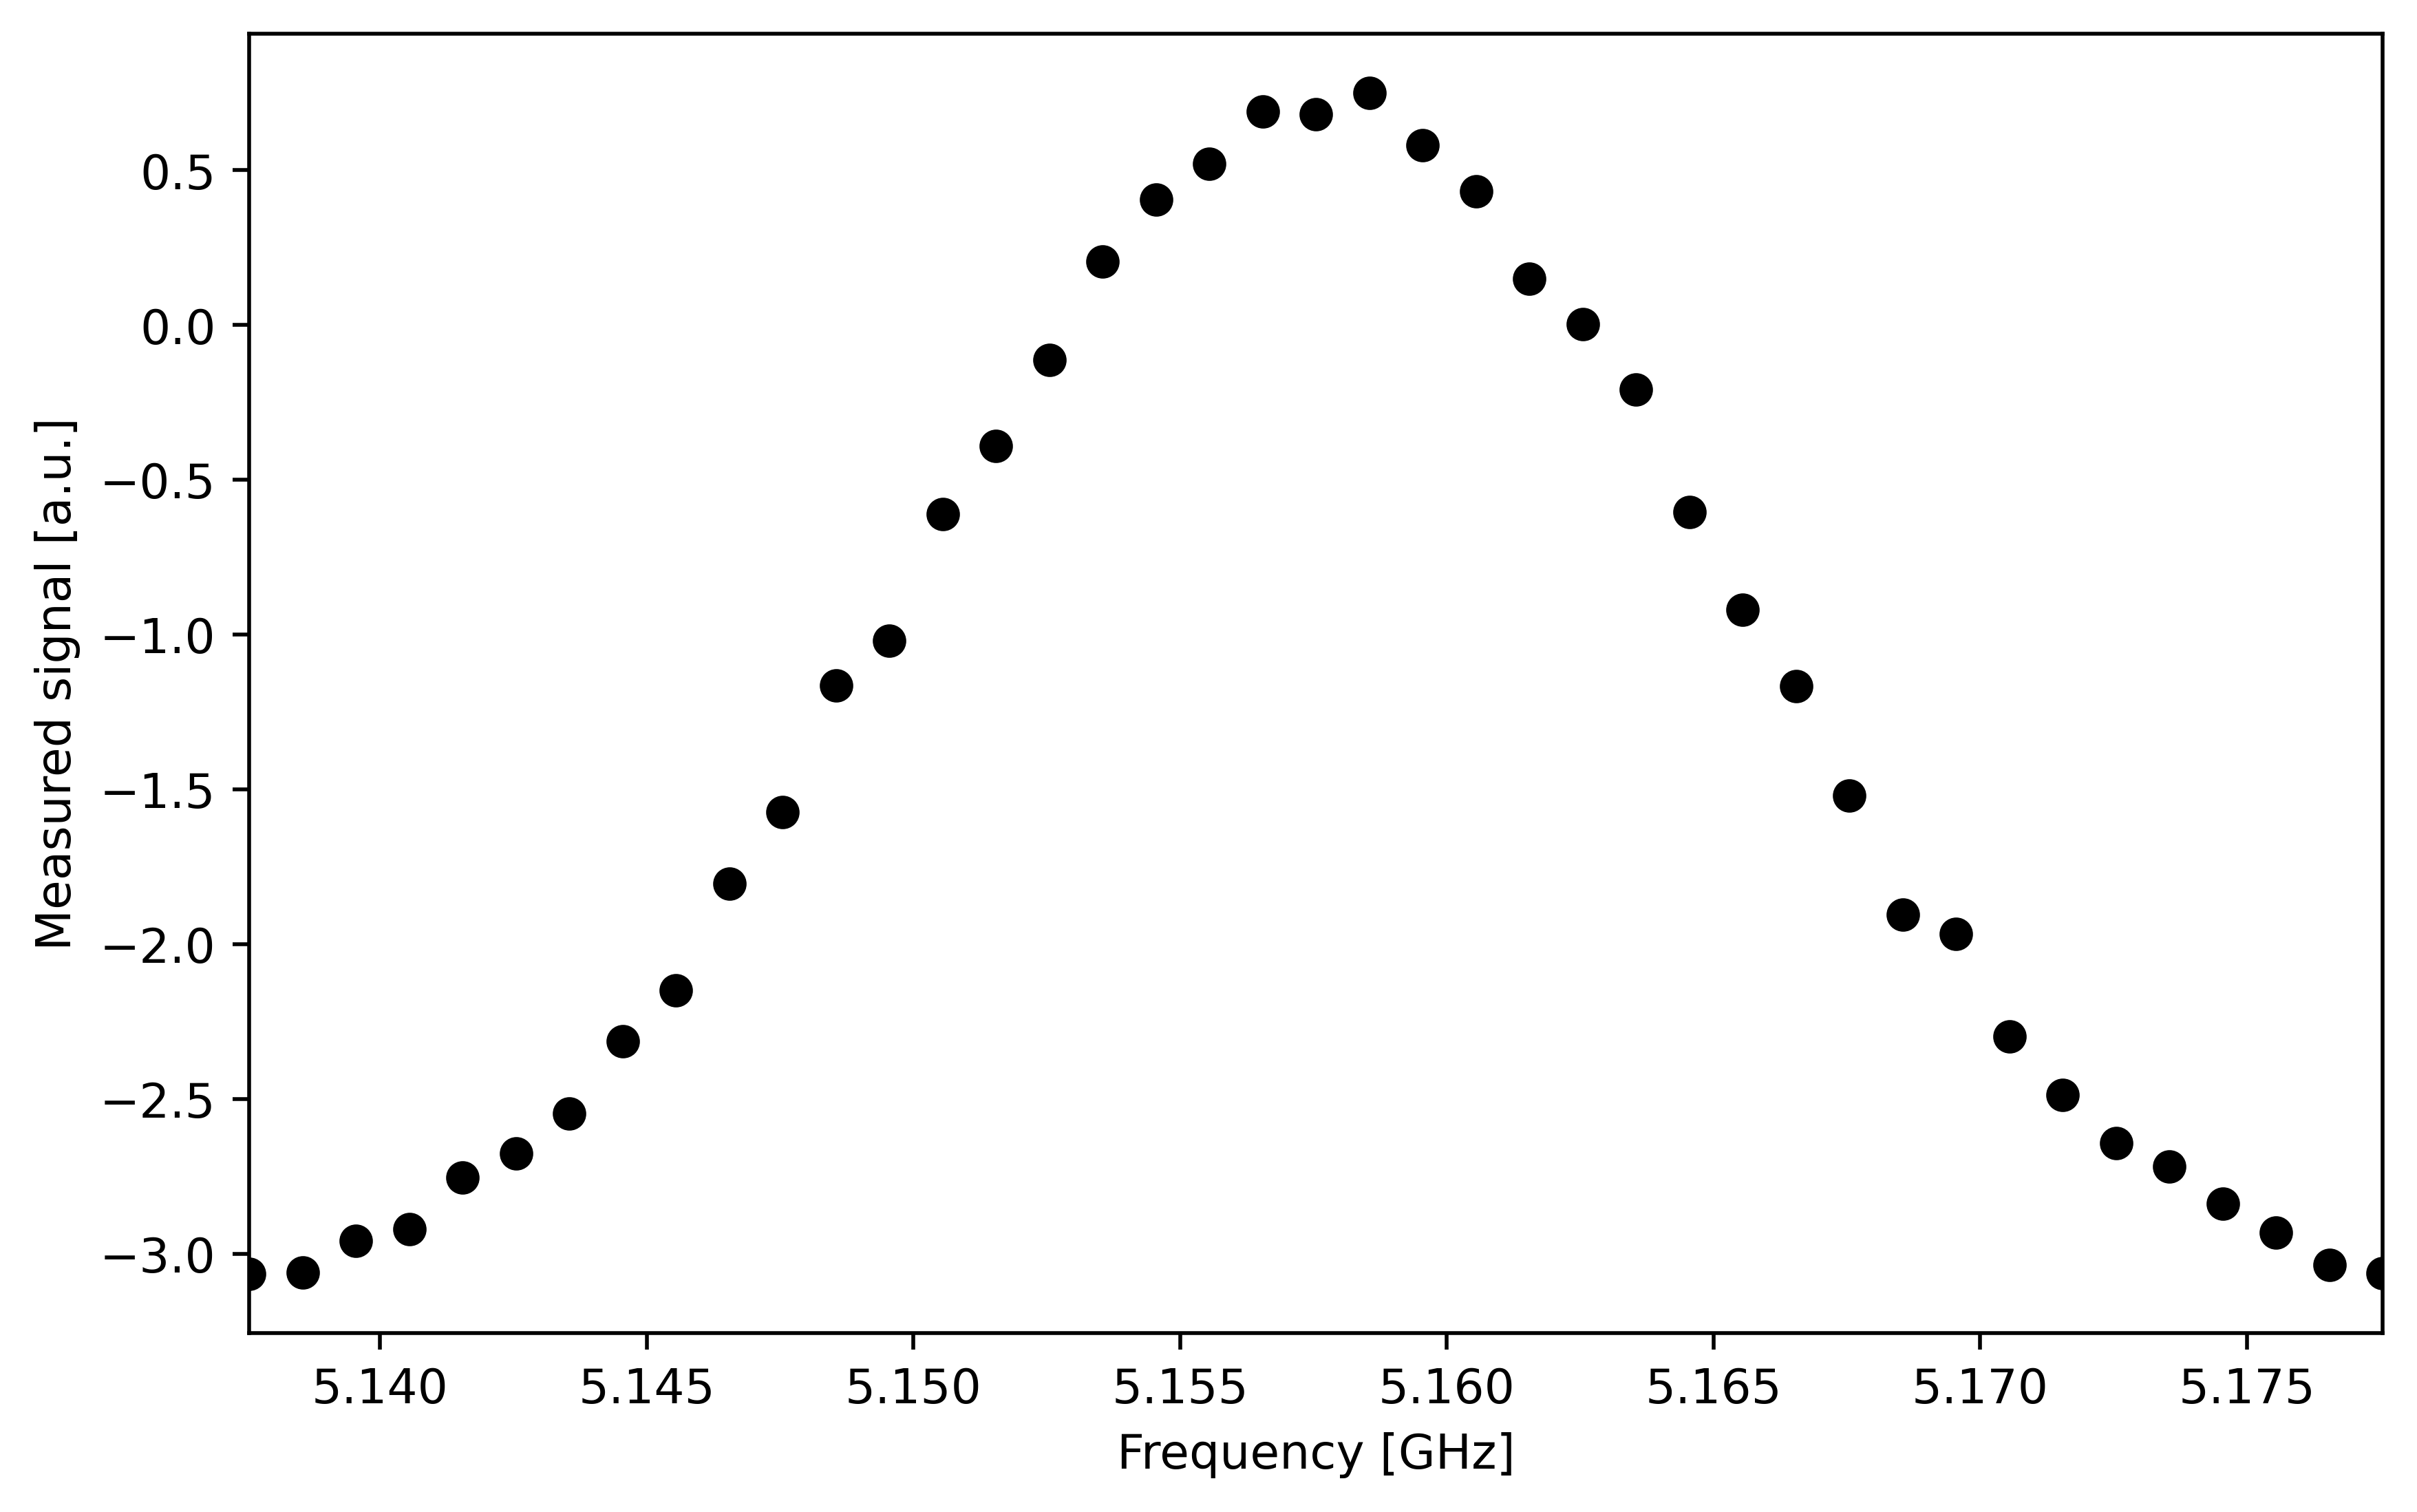

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5), dpi=500)

sweep_values = []
for i in range(len(frequency_sweep_results.results)):
    # Get the results from the ith experiment
    res = frequency_sweep_results.get_memory(i)*scale_factor
    # Get the results for `qubit` from this experiment
    sweep_values.append(res[qubit])

plt.scatter(frequencies_GHz, np.real(sweep_values), color='black') # plot real part of sweep values
plt.xlim([min(frequencies_GHz), max(frequencies_GHz)])
plt.xlabel("Frequency [GHz]")
plt.ylabel("Measured signal [a.u.]")
plt.show()

In [ ]:
from scipy.optimize import curve_fit

def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
    y_fit = function(x_values, *fitparams)
    
    return fitparams, y_fit

In [ ]:
fit_params, y_fit = fit_function(frequencies_GHz,
                                 np.real(sweep_values), 
                                 lambda x, A, q_freq, B, C: (A / np.pi) * (B / ((x - q_freq)**2 + B**2)) + C,
                                 [1, 4.975, 1, -2] # initial parameters for curve_fit
                                )

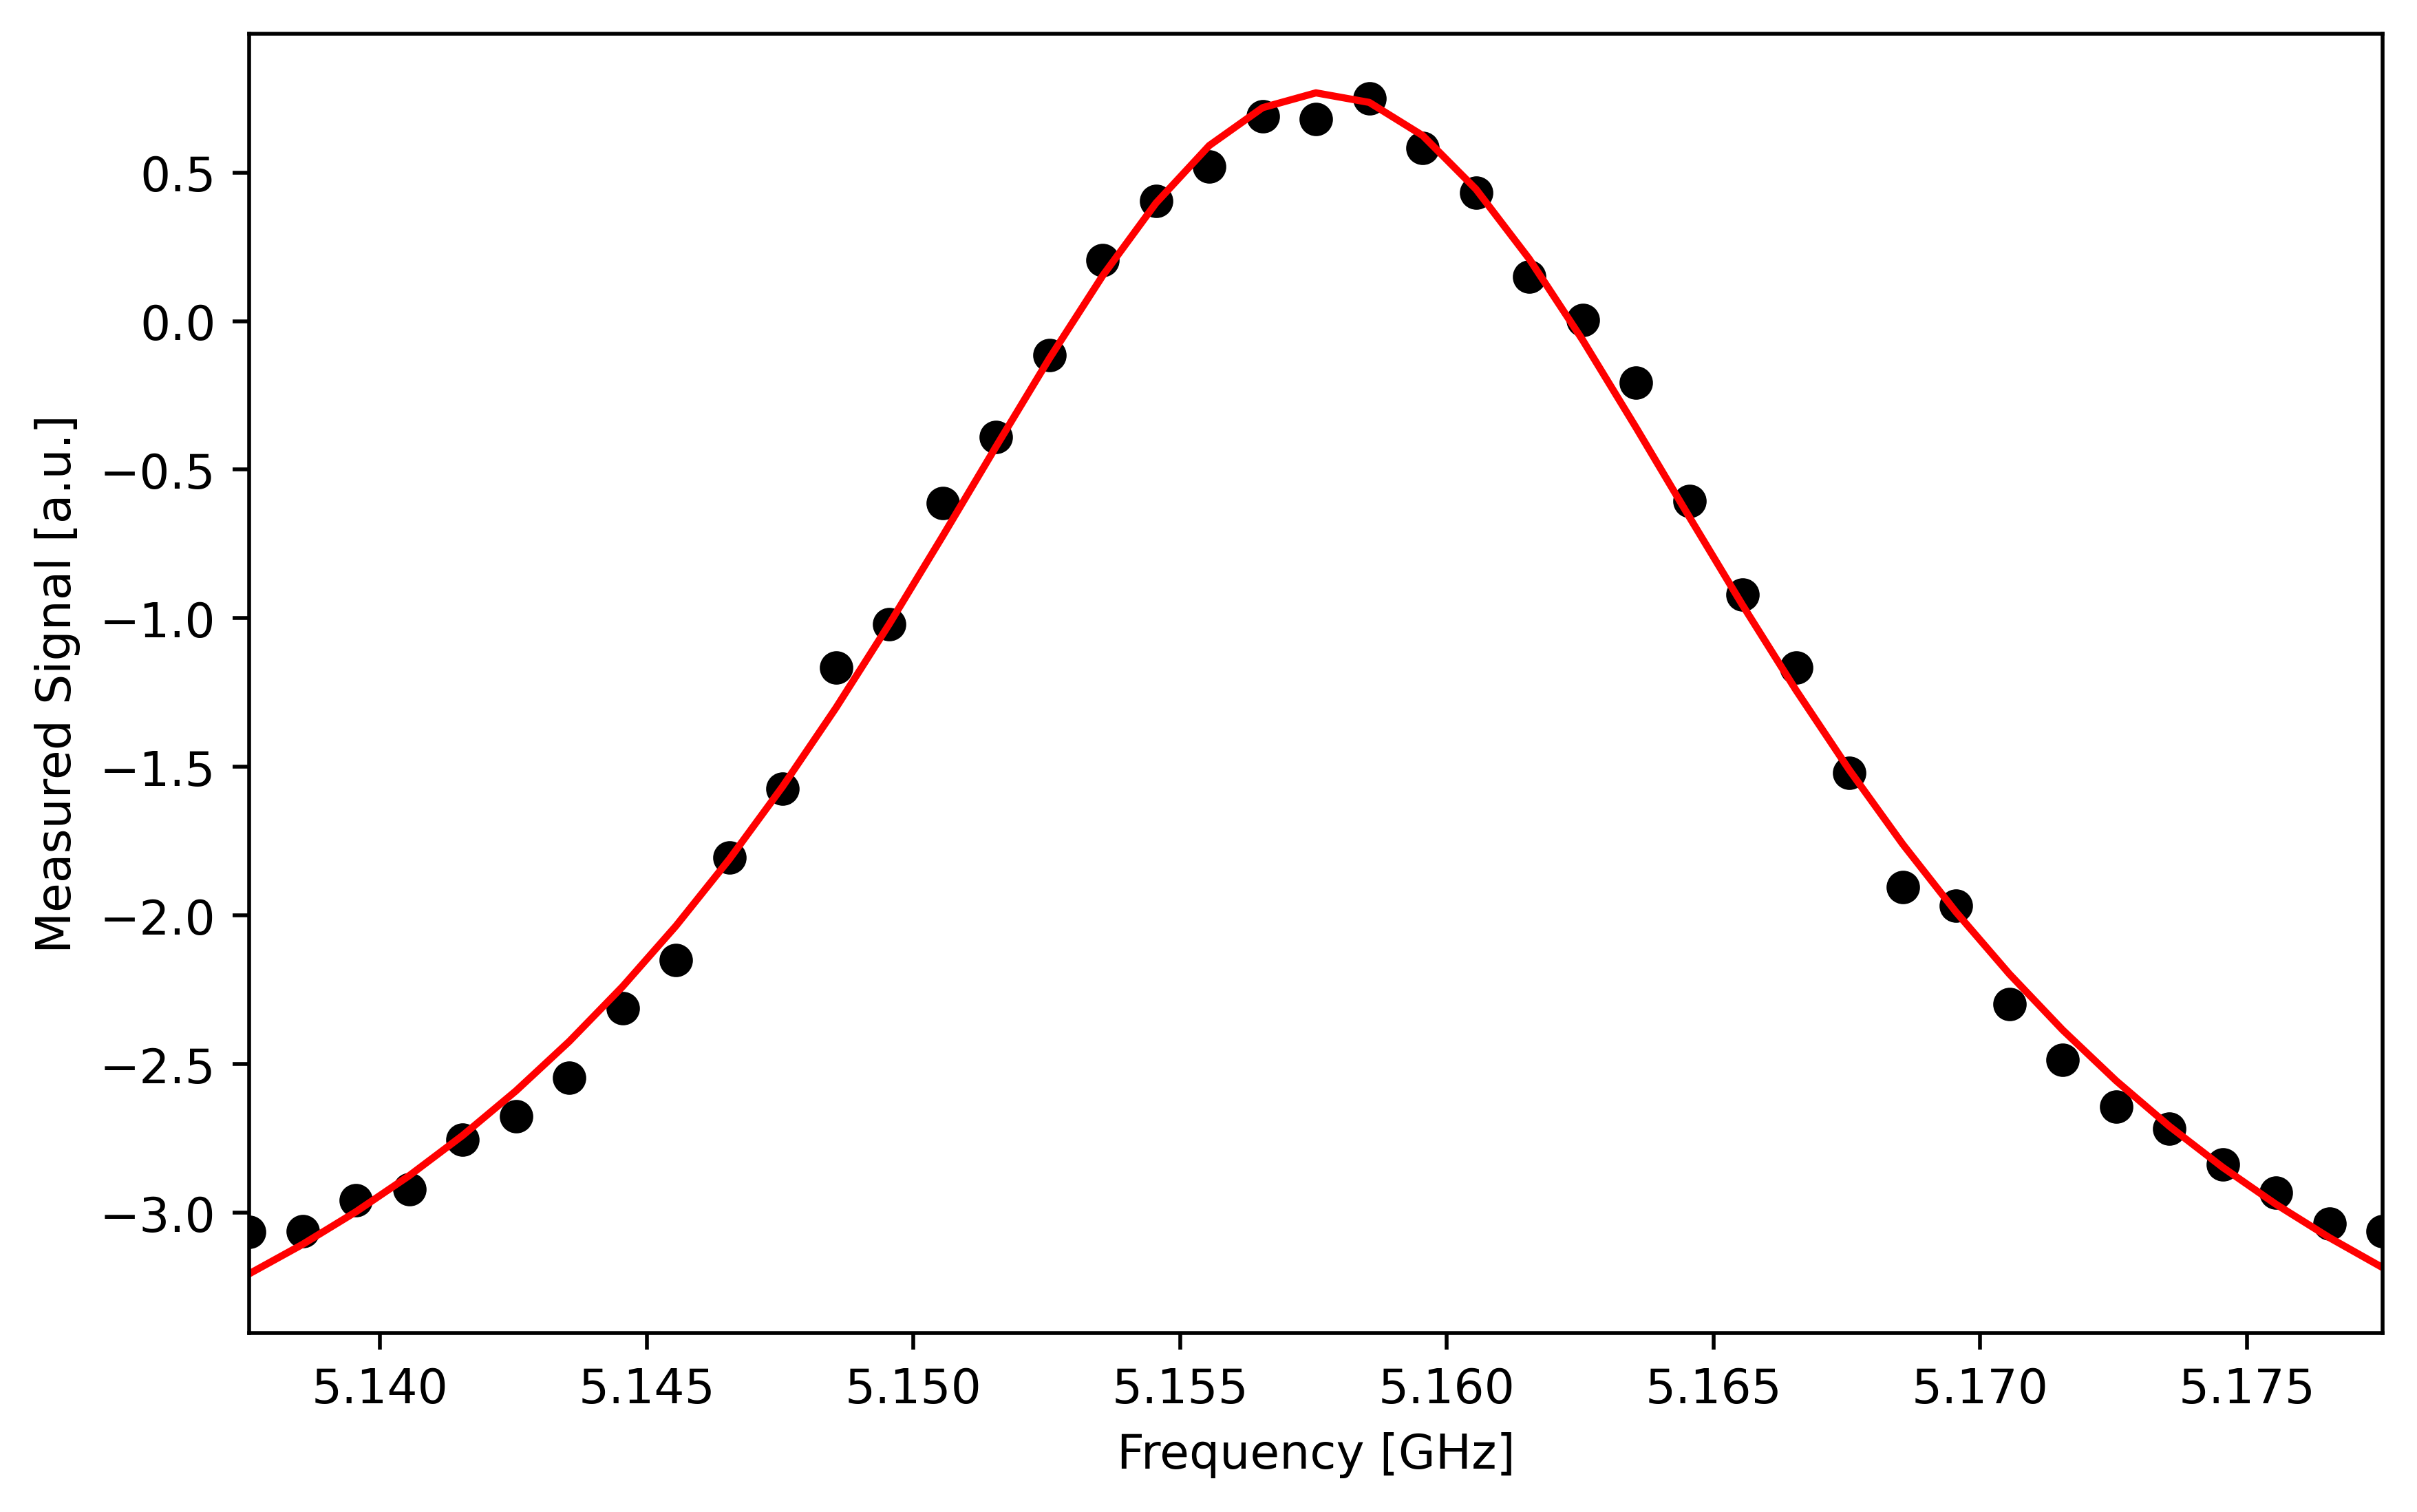

In [ ]:
plt.figure(figsize=(8,5), dpi=500)
plt.scatter(frequencies_GHz, np.real(sweep_values), color='black')
plt.plot(frequencies_GHz, y_fit, color='red')
plt.xlim([min(frequencies_GHz), max(frequencies_GHz)])

plt.xlabel("Frequency [GHz]")
plt.ylabel("Measured Signal [a.u.]")
plt.show()

In [ ]:
A, rough_qubit_frequency, B, C = fit_params
rough_qubit_frequency = rough_qubit_frequency*GHz # make sure qubit freq is in Hz
print(f"We've updated our qubit frequency estimate from "
      f"{round(backend_defaults.qubit_freq_est[qubit] / GHz, 5)} GHz to {round(rough_qubit_frequency/GHz, 5)} GHz.")

We've updated our qubit frequency estimate from 5.15754 GHz to 5.15765 GHz.


Calibrating and using a pi pulse.


In [ ]:
# This experiment uses these values from the previous experiment:
# `qubit`,and
# `rough_qubit_frequency`.

# Rabi experiment parameters
num_rabi_points = 50

# Drive amplitude values to iterate over: 50 amplitudes evenly spaced from 0 to 0.75
drive_amp_min = 0
drive_amp_max = 0.75
drive_amps = np.linspace(drive_amp_min, drive_amp_max, num_rabi_points)

In [ ]:
# Build the Rabi experiments:
#    A drive pulse at the qubit frequency, followed by a measurement,
#    where we vary the drive amplitude each time.

drive_amp = Parameter('drive_amp')
with pulse.build(backend=backend, default_alignment='sequential', name='Rabi Experiment') as rabi_sched:
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(rough_qubit_frequency, drive_chan)
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              amp=drive_amp,
                              sigma=drive_sigma,
                              name='Rabi Pulse'), drive_chan)

In [ ]:
rabi_gate = Gate("rabi", 1, [drive_amp])

qc_rabi = QuantumCircuit(1, 1)

qc_rabi.append(rabi_gate, [0])
qc_rabi.measure(0, 0)
qc_rabi.add_calibration(rabi_gate, (0,), rabi_sched, [drive_amp])

exp_rabi_circs = [qc_rabi.assign_parameters({drive_amp: a}, inplace=False) for a in drive_amps]

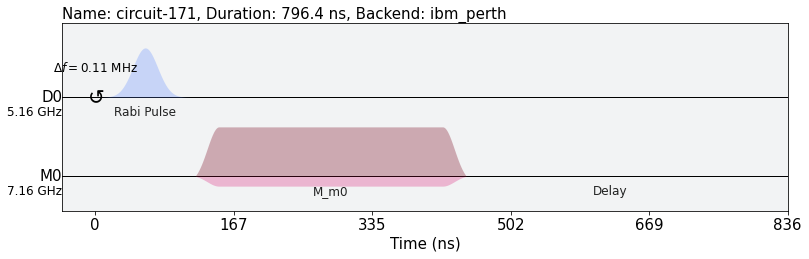

In [ ]:
rabi_schedule = schedule(exp_rabi_circs[-1], backend)
rabi_schedule.draw(backend=backend)

In [ ]:
num_shots_per_point = 1024

job = backend.run(exp_rabi_circs, 
                  meas_level=1, 
                  meas_return='avg', 
                  shots=num_shots_per_point)

job_monitor(job)

Job Status: job has successfully run


In [ ]:
rabi_results = job.result(timeout=120)

In [ ]:
# center data around 0
def baseline_remove(values):
    return np.array(values) - np.mean(values)

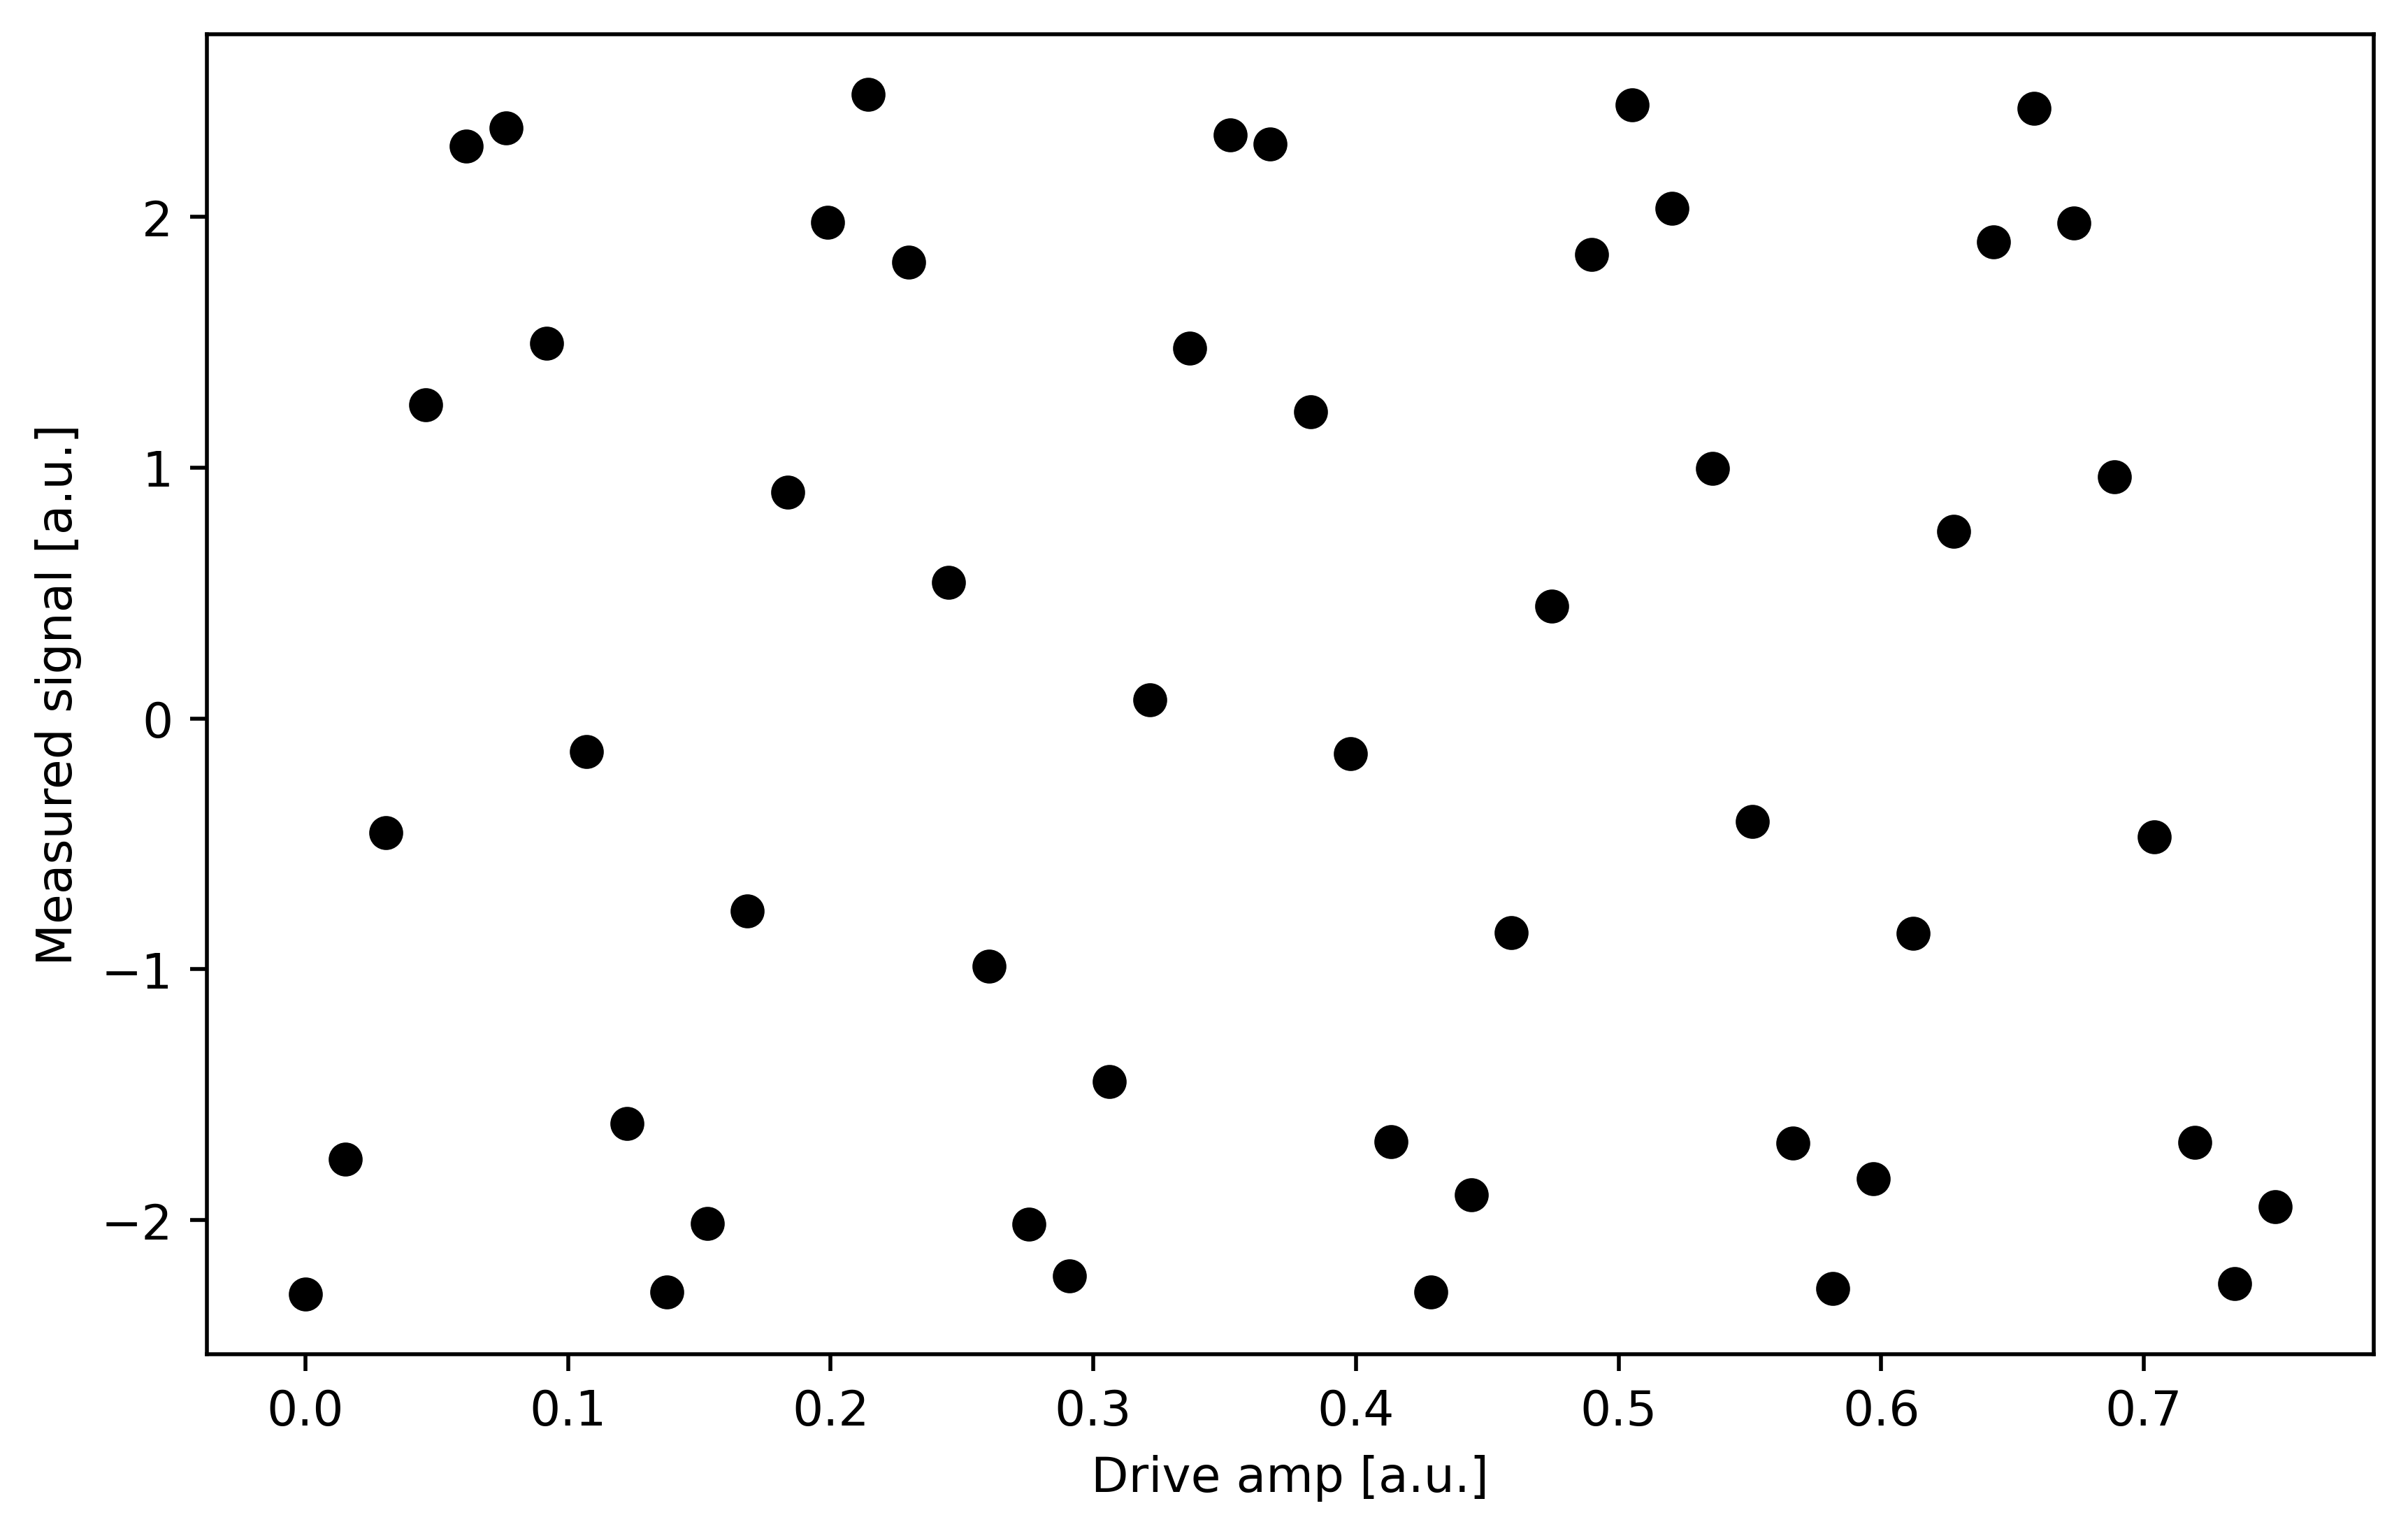

In [ ]:
rabi_values = []
for i in range(num_rabi_points):
    # Get the results for `qubit` from the ith experiment
    rabi_values.append(rabi_results.get_memory(i)[qubit] * scale_factor)

rabi_values = np.real(baseline_remove(rabi_values))

plt.figure(figsize=(8,5), dpi=500)

plt.xlabel("Drive amp [a.u.]")
plt.ylabel("Measured signal [a.u.]")
plt.scatter(drive_amps, rabi_values, color='black') # plot real part of Rabi values
plt.show()

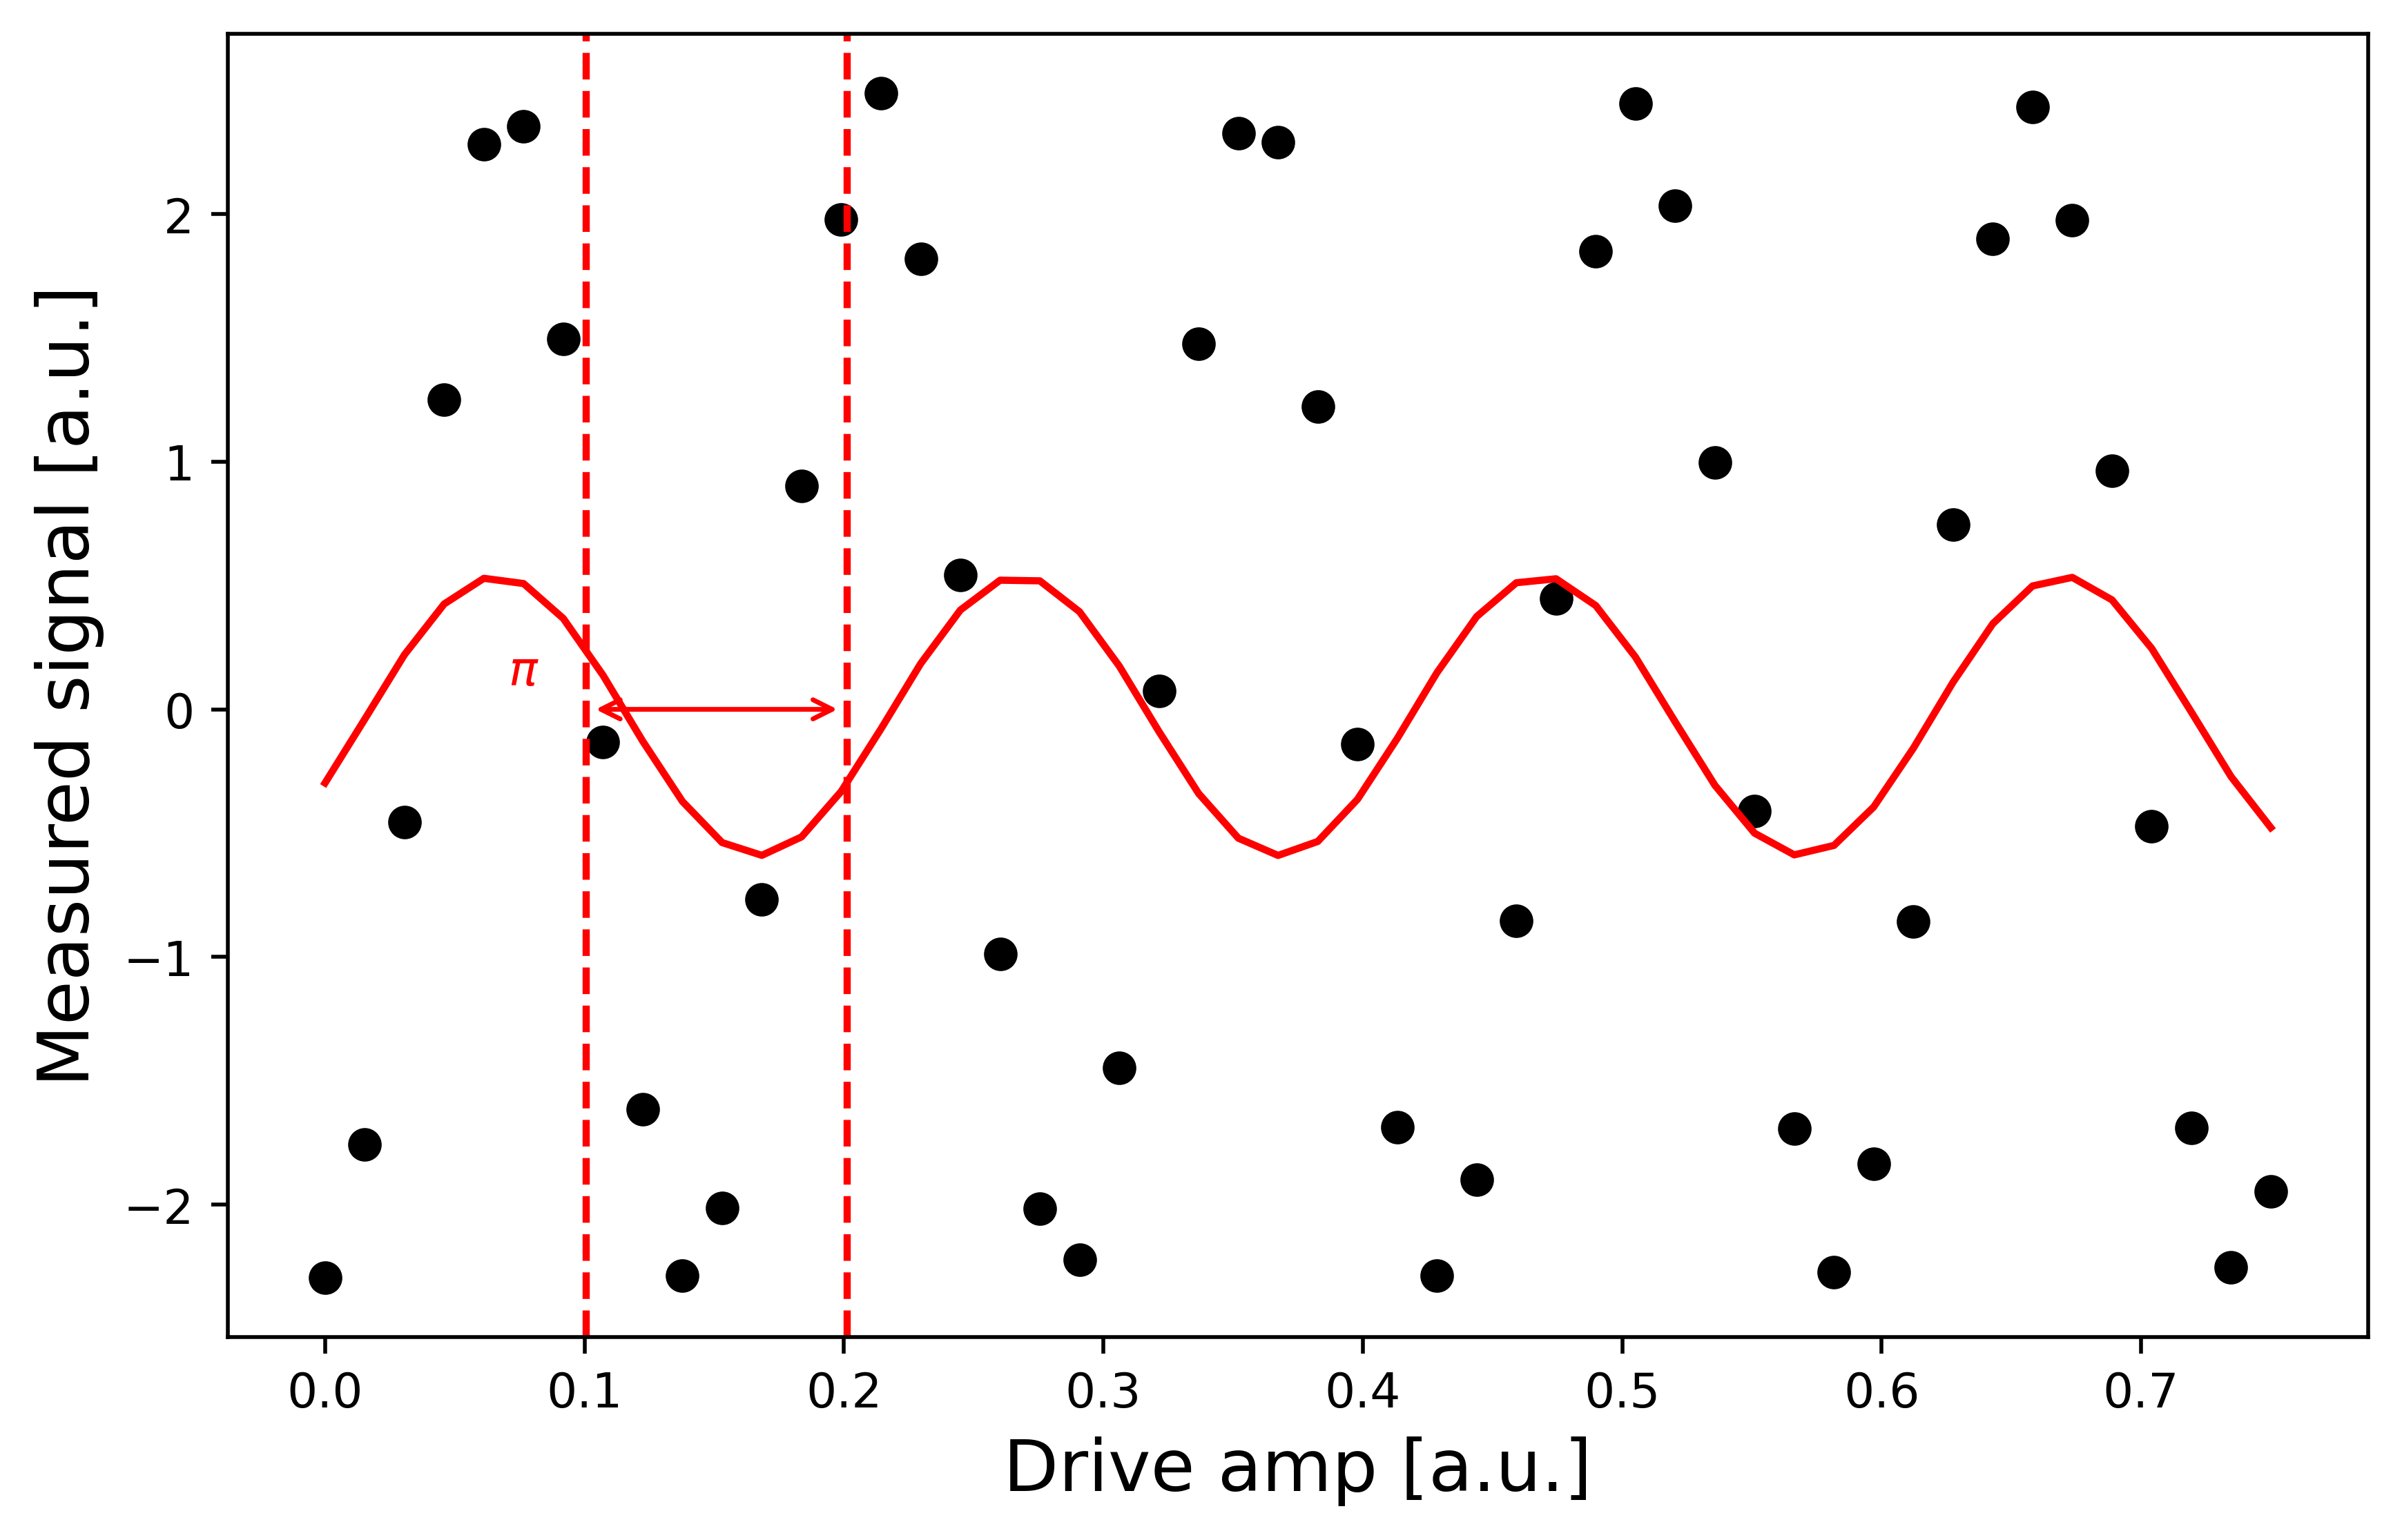

In [ ]:
fit_params, y_fit = fit_function(drive_amps,
                                 rabi_values, 
                                 lambda x, A, B, drive_period, phi: (A*np.cos(2*np.pi*x/drive_period - phi) + B),
                                 [2, 0, 0.2, 0])

plt.figure(figsize=(8,5), dpi=500)

plt.scatter(drive_amps, rabi_values, color='black')
plt.plot(drive_amps, y_fit, color='red')

drive_period = fit_params[2] # get period of rabi oscillation

plt.axvline(drive_period/2, color='red', linestyle='--')
plt.axvline(drive_period, color='red', linestyle='--')
plt.annotate("", xy=(drive_period, 0), xytext=(drive_period/2,0), arrowprops=dict(arrowstyle="<->", color='red'))
plt.annotate("$\pi$", xy=(drive_period/2-0.03, 0.1), color='red')

plt.xlabel("Drive amp [a.u.]", fontsize=15)
plt.ylabel("Measured signal [a.u.]", fontsize=15)
plt.show()

In [ ]:
pi_amp = abs(drive_period / 2)
print(f"Pi Amplitude = {pi_amp}")

Pi Amplitude = 0.1006080727453086


Here we define the pulse.

In [ ]:
with pulse.build(backend) as pi_pulse:
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(qubit)
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              amp=pi_amp,
                              sigma=drive_sigma,
                              name='pi_pulse'), drive_chan)

In [ ]:
# Ground state 
qc_gnd = QuantumCircuit(1, 1)
qc_gnd.measure(0, 0)

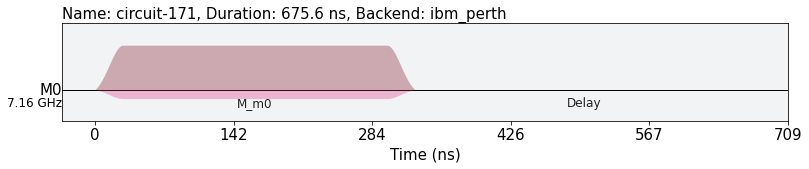

In [ ]:
gnd_schedule = schedule(qc_gnd, backend)
gnd_schedule.draw(backend=backend)

In [ ]:
# Excited state
with pulse.build(backend=backend, default_alignment='sequential', name='excited state') as exc_schedule:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(rough_qubit_frequency, drive_chan)
    pulse.call(pi_pulse)

In [ ]:
qc_exc = QuantumCircuit(1, 1)
qc_exc.x(0)
qc_exc.measure(0, 0)

qc_exc.add_calibration("x", (0,), exc_schedule, [])

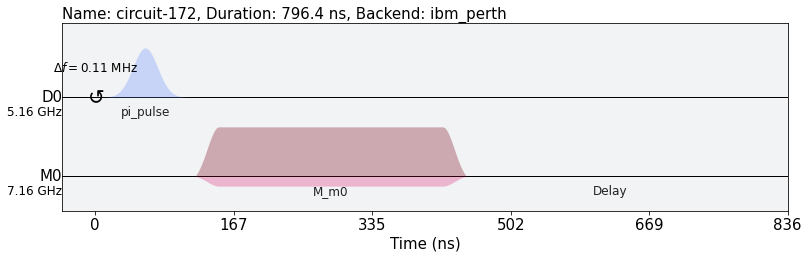

In [ ]:
exec_schedule = schedule(qc_exc, backend)
exec_schedule.draw(backend=backend)

In [ ]:
# Execution settings
num_shots = 500

job = backend.run([qc_gnd, qc_exc], 
                  meas_level=1, 
                  meas_return='single', 
                  shots=num_shots)

job_monitor(job)

Job Status: job has successfully run


In [ ]:
gnd_exc_results = job.result(timeout=400)

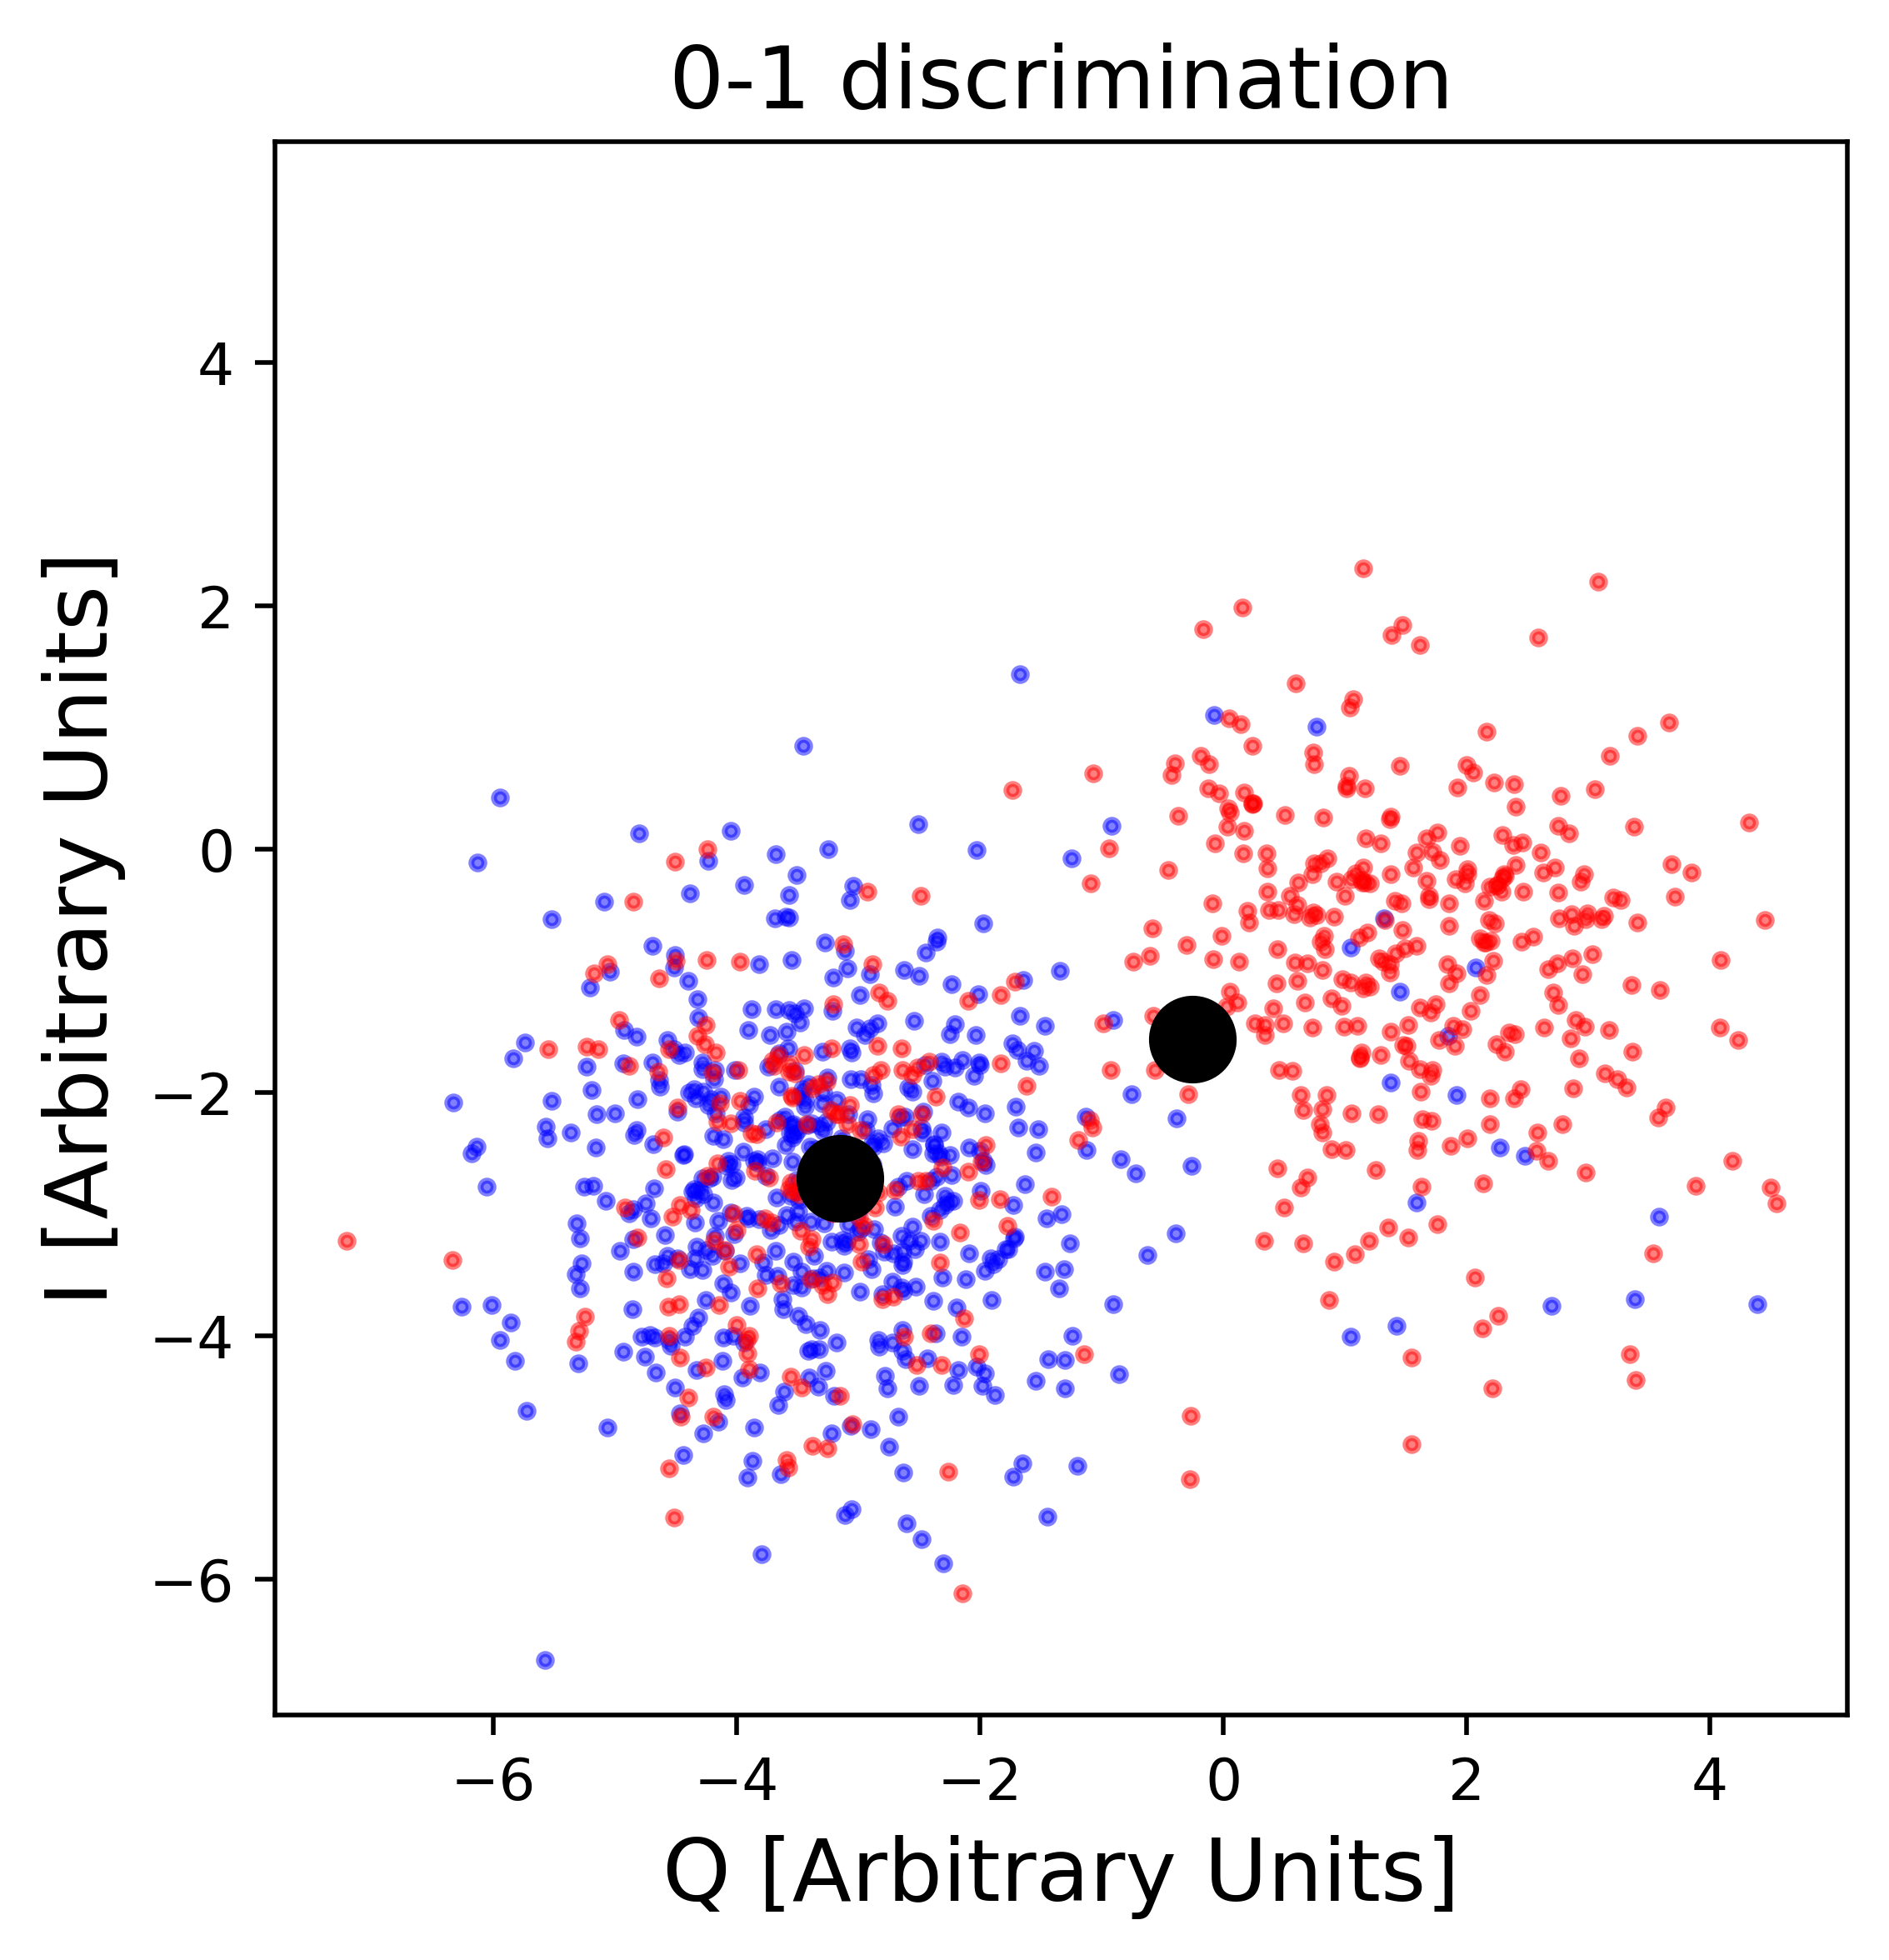

In [ ]:
gnd_results = gnd_exc_results.get_memory(0)[:, qubit]*scale_factor
exc_results = gnd_exc_results.get_memory(1)[:, qubit]*scale_factor


plt.figure(figsize=(8,5), dpi=500)

# Plot all the results
# All results from the ground state are plotted in blue
plt.scatter(np.real(gnd_results), np.imag(gnd_results), 
                s=5, cmap='viridis', c='blue', alpha=0.5, label='state_0')
# All results from the excited state are plotted in red
plt.scatter(np.real(exc_results), np.imag(exc_results), 
                s=5, cmap='viridis', c='red', alpha=0.5, label='state_1')

plt.axis('square')

# Plot a large dot for the average result of the 0 and 1 states.
mean_gnd = np.mean(gnd_results) # takes mean of both real and imaginary parts
mean_exc = np.mean(exc_results)
plt.scatter(np.real(mean_gnd), np.imag(mean_gnd), 
            s=200, cmap='viridis', c='black',alpha=1.0, label='state_0_mean')
plt.scatter(np.real(mean_exc), np.imag(mean_exc), 
            s=200, cmap='viridis', c='black',alpha=1.0, label='state_1_mean')

plt.ylabel('I [Arbitrary Units]', fontsize=15)
plt.xlabel('Q [Arbitrary Units]', fontsize=15)
plt.title("0-1 discrimination", fontsize=15)

plt.show()

In [ ]:
import math

def classify(point: complex):
    """Classify the given state as |0> or |1>."""
    def distance(a, b):
        return math.sqrt((np.real(a) - np.real(b))**2 + (np.imag(a) - np.imag(b))**2)
    return int(distance(point, mean_exc) < distance(point, mean_gnd))


In [ ]:
# T1 experiment parameters
time_max_sec = 450 * us
time_step_sec = 6.5 * us
delay_times_sec = np.arange(1 * us, time_max_sec, time_step_sec)

# We will use the same `pi_pulse` and qubit frequency that we calibrated and used before

In [ ]:
delay = Parameter('delay')
qc_t1 = QuantumCircuit(1, 1)

qc_t1.x(0)
qc_t1.delay(delay, 0)
qc_t1.measure(0, 0)
qc_t1.add_calibration("x", (0,), pi_pulse)

exp_t1_circs = [qc_t1.assign_parameters({delay: get_dt_from(d)}, inplace=False) for d in delay_times_sec]

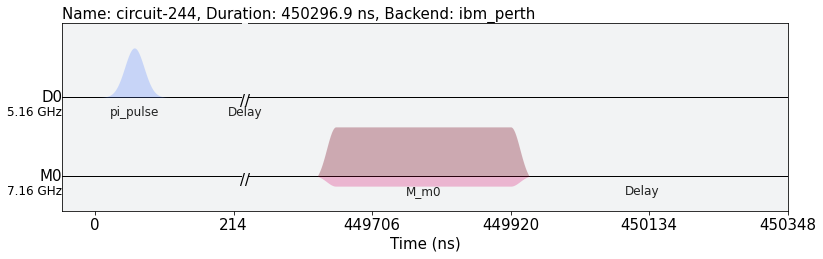

In [ ]:
sched_idx = -1
t1_schedule = schedule(exp_t1_circs[sched_idx], backend)
t1_schedule.draw(backend=backend)

In [ ]:
# Execution settings
num_shots = 256

job = backend.run(exp_t1_circs, 
                  meas_level=1, 
                  meas_return='single', 
                  shots=num_shots)

job_monitor(job)

Job Status: job has successfully run


In [ ]:
t1_results = job.result(timeout=120)

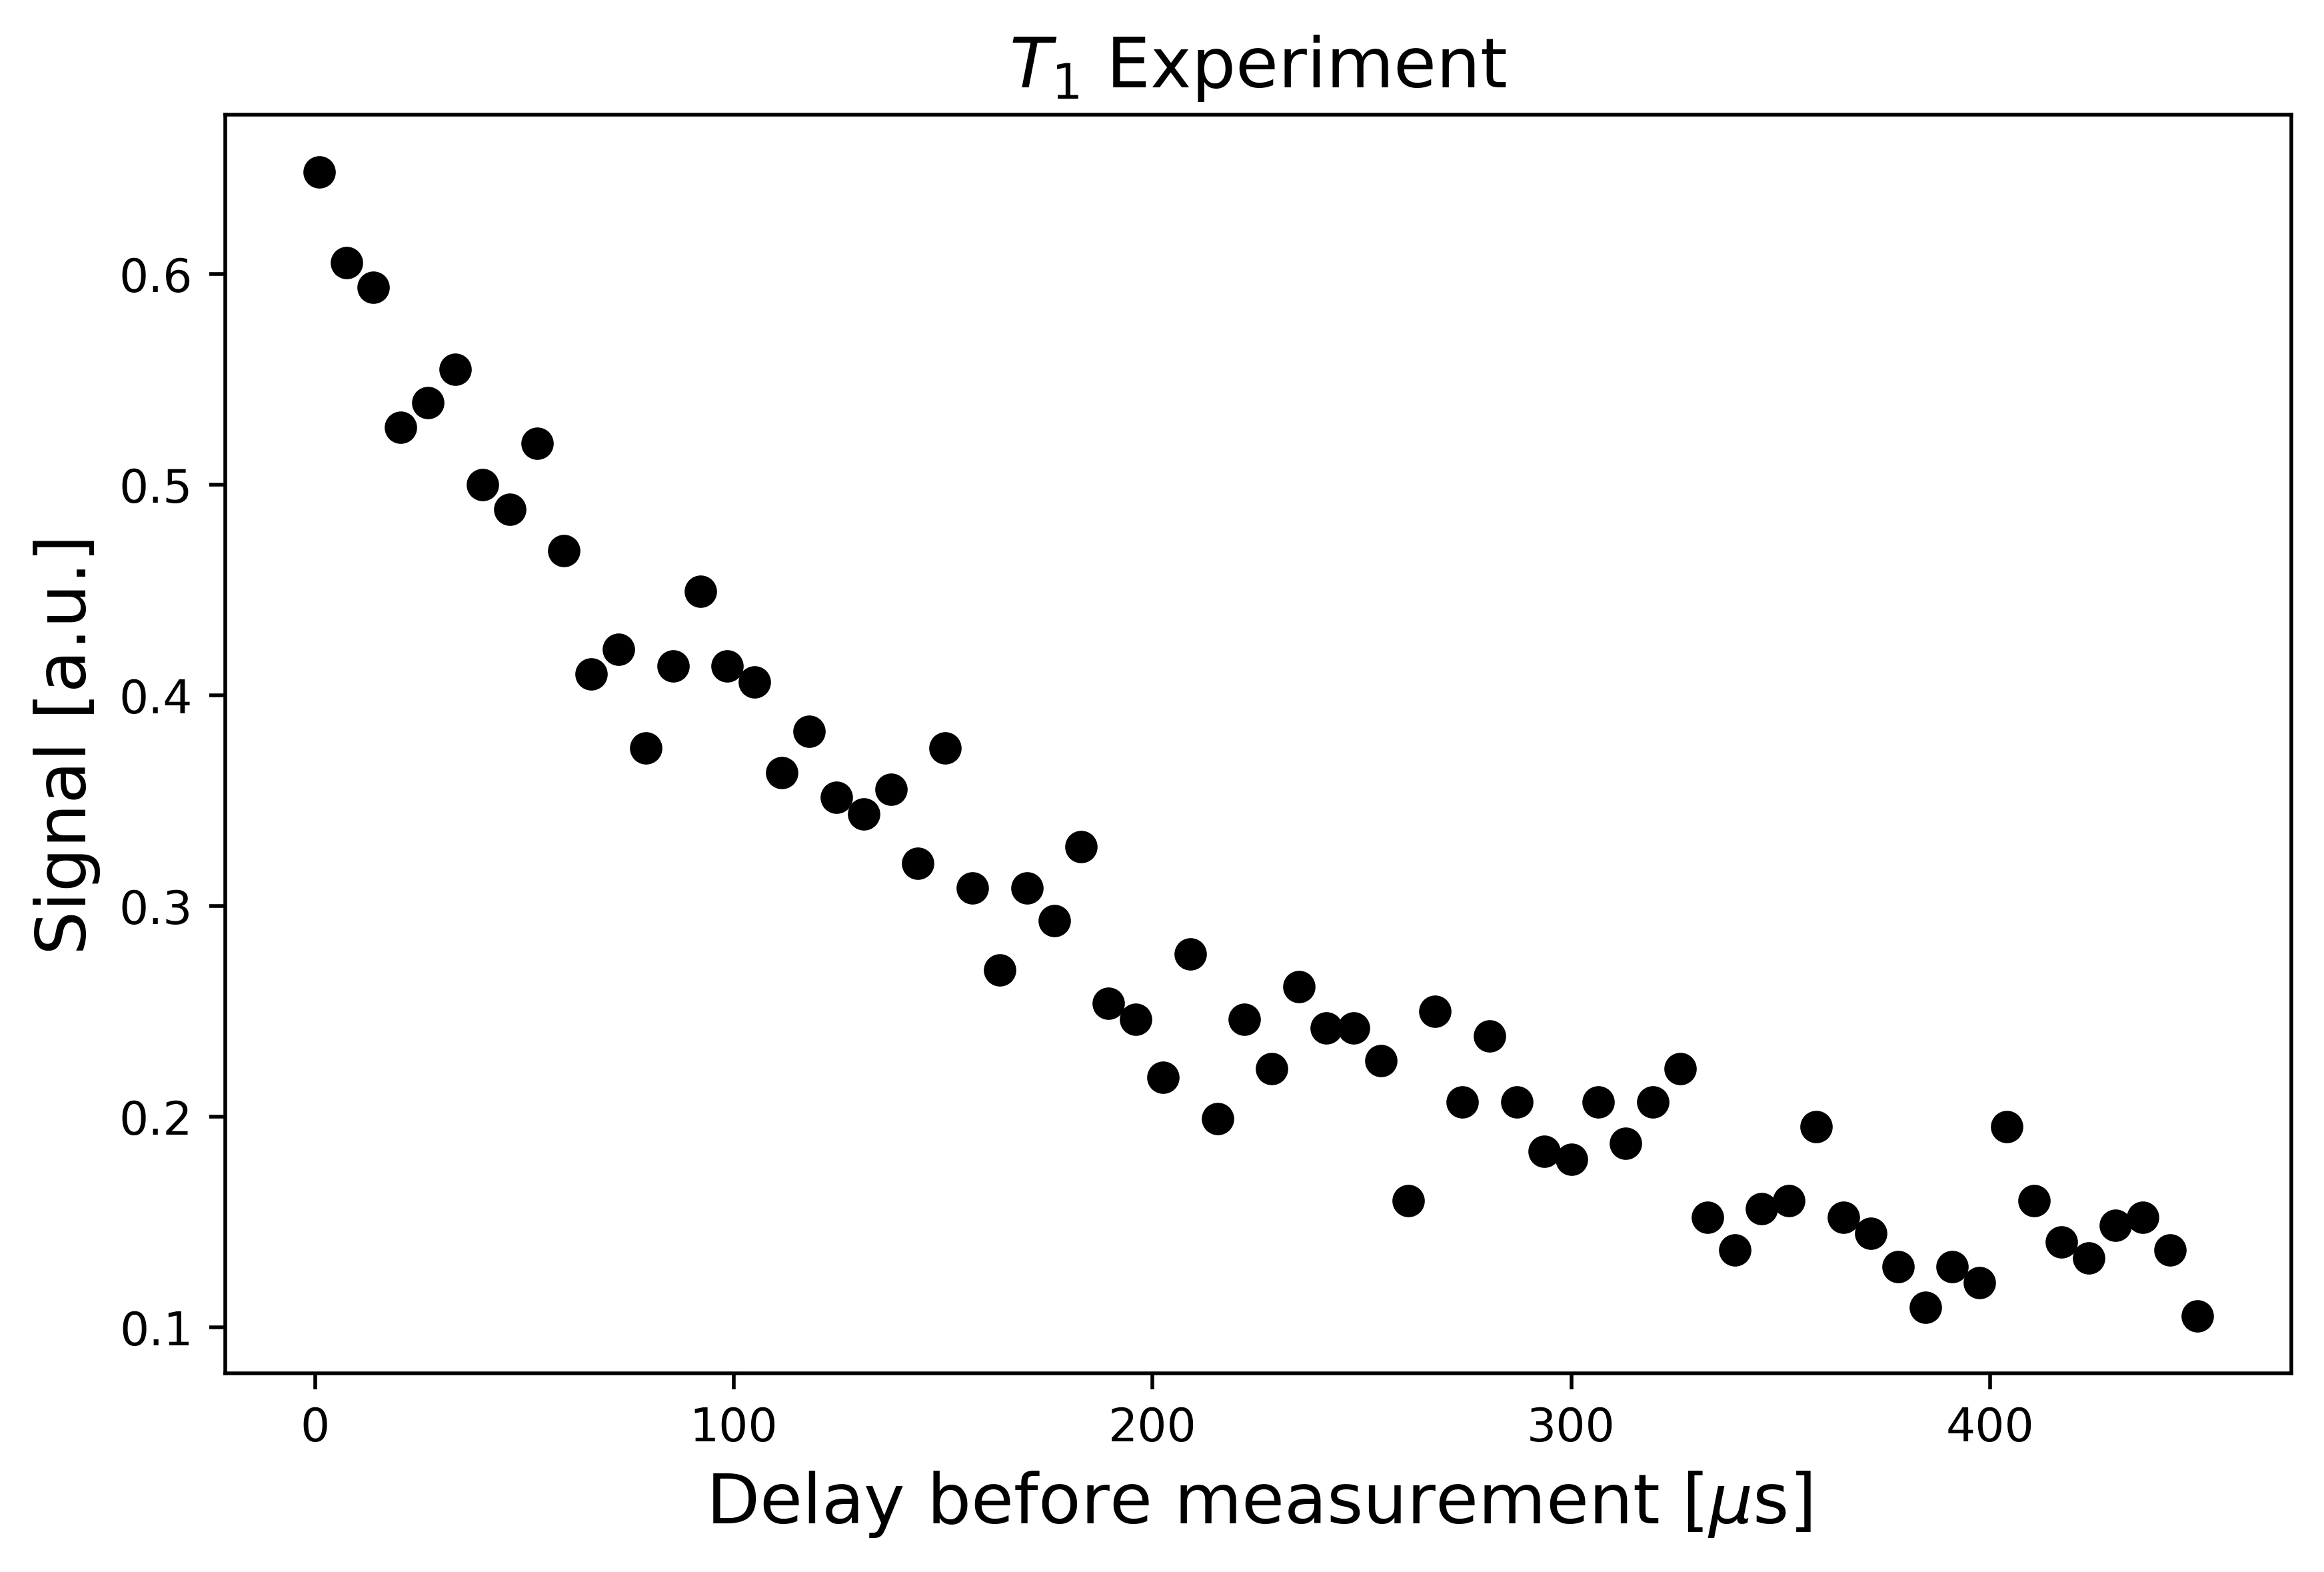

In [ ]:
t1_values = []

for i in range(len(delay_times_sec)):
    iq_data = t1_results.get_memory(i)[:,qubit] * scale_factor
    t1_values.append(sum(map(classify, iq_data)) / num_shots)

plt.figure(figsize=(8,5), dpi=500)
plt.scatter(delay_times_sec/us, t1_values, color='black') 
plt.title("$T_1$ Experiment", fontsize=15)
plt.xlabel('Delay before measurement [$\mu$s]', fontsize=15)
plt.ylabel('Signal [a.u.]', fontsize=15)
plt.show()

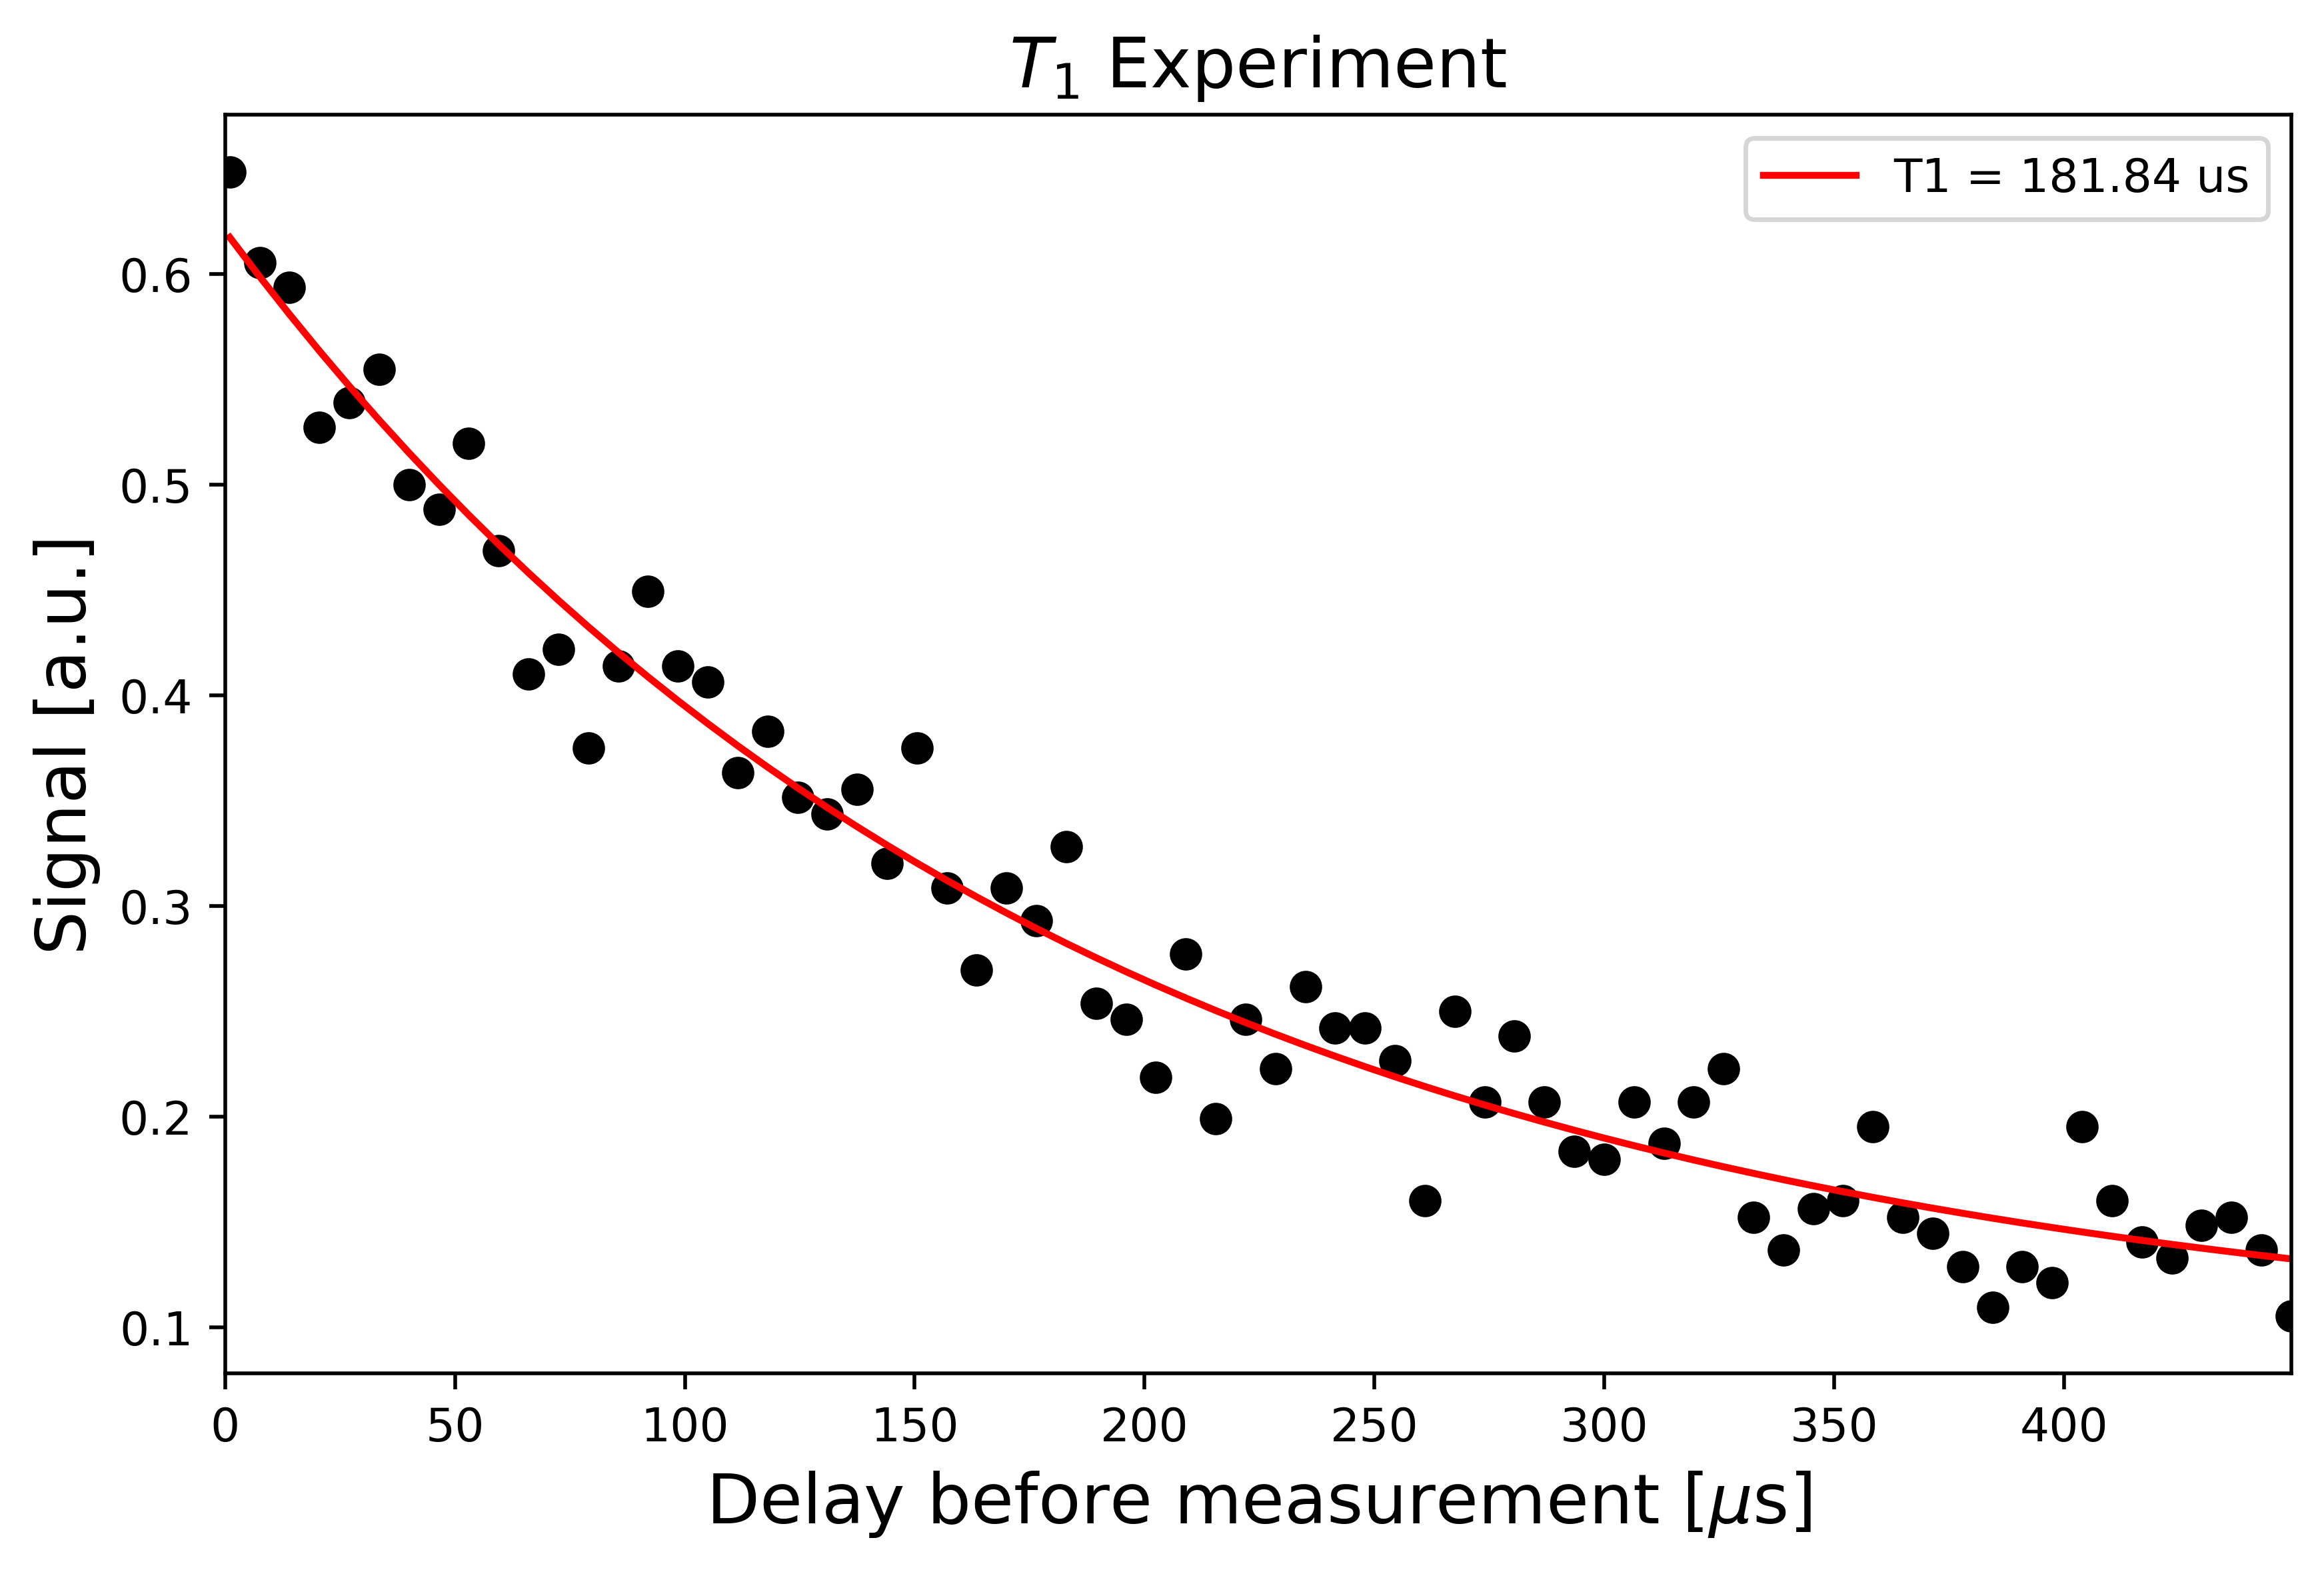

In [ ]:
# Fit the data
fit_params, y_fit = fit_function(delay_times_sec/us, t1_values, 
            lambda x, A, C, T1: (A * np.exp(-x / T1) + C),
            [-3, 3, 100]
            )

_, _, T1 = fit_params

plt.figure(figsize=(8,5), dpi=500)
plt.scatter(delay_times_sec/us, t1_values, color='black')
plt.plot(delay_times_sec/us, y_fit, color='red', label=f"T1 = {T1:.2f} us")
plt.xlim(0, np.max(delay_times_sec/us))
plt.title("$T_1$ Experiment", fontsize=15)
plt.xlabel('Delay before measurement [$\mu$s]', fontsize=15)
plt.ylabel('Signal [a.u.]', fontsize=15)
plt.legend()
plt.show()

Ramsey experiment.

In [ ]:
# Ramsey experiment parameters
time_max_sec = 1.8 * us
time_step_sec = 0.025 * us
delay_times_sec = np.arange(0.1 * us, time_max_sec, time_step_sec)

# Drive parameters
# The drive amplitude for pi/2 is simply half the amplitude of the pi pulse
drive_amp = pi_amp / 2

# x_90 is a concise way to say pi_over_2; i.e., an X rotation of 90 degrees
with pulse.build(backend) as x90_pulse:
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(qubit)
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              amp=drive_amp,
                              sigma=drive_sigma,
                              name='x90_pulse'), drive_chan)

In [ ]:
detuning_MHz = 2 
ramsey_frequency = round(rough_qubit_frequency + detuning_MHz * MHz, 6) # need ramsey freq in Hz

In [ ]:
# create schedules for Ramsey experiment 
delay = Parameter('delay')
with pulse.build(backend=backend, default_alignment='sequential', name="Ramsey delay Experiment") as ramsey_schedule:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(ramsey_frequency, drive_chan)
    pulse.call(x90_pulse)
    pulse.delay(delay, drive_chan)
    pulse.call(x90_pulse)

In [ ]:
ramsey_gate = Gate("ramsey", 1, [delay])

qc_ramsey = QuantumCircuit(1, 1)

qc_ramsey.append(ramsey_gate, [0])
qc_ramsey.measure(0, 0)
qc_ramsey.add_calibration(ramsey_gate, (0,), ramsey_schedule, [delay])

exp_ramsey_circs = [qc_ramsey.assign_parameters({delay: get_dt_from(d)}, inplace=False) for d in delay_times_sec]

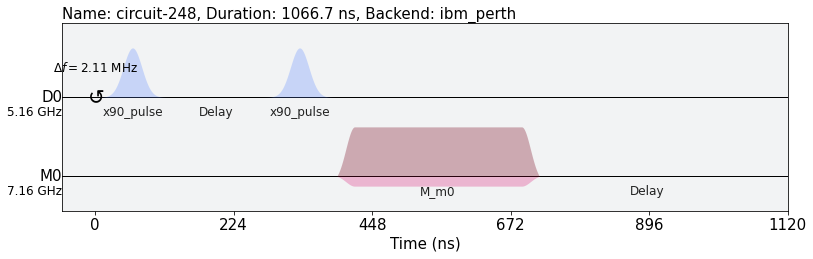

In [ ]:
ramsey_schedule = schedule(exp_ramsey_circs[2], backend)
ramsey_schedule.draw(backend=backend)

In [ ]:
# Execution settings
num_shots = 256

job = backend.run(exp_ramsey_circs, 
                  meas_level=1, 
                  meas_return='single', 
                  shots=num_shots)

job_monitor(job)

Job Status: job has successfully run


In [ ]:
ramsey_results = job.result(timeout=120)

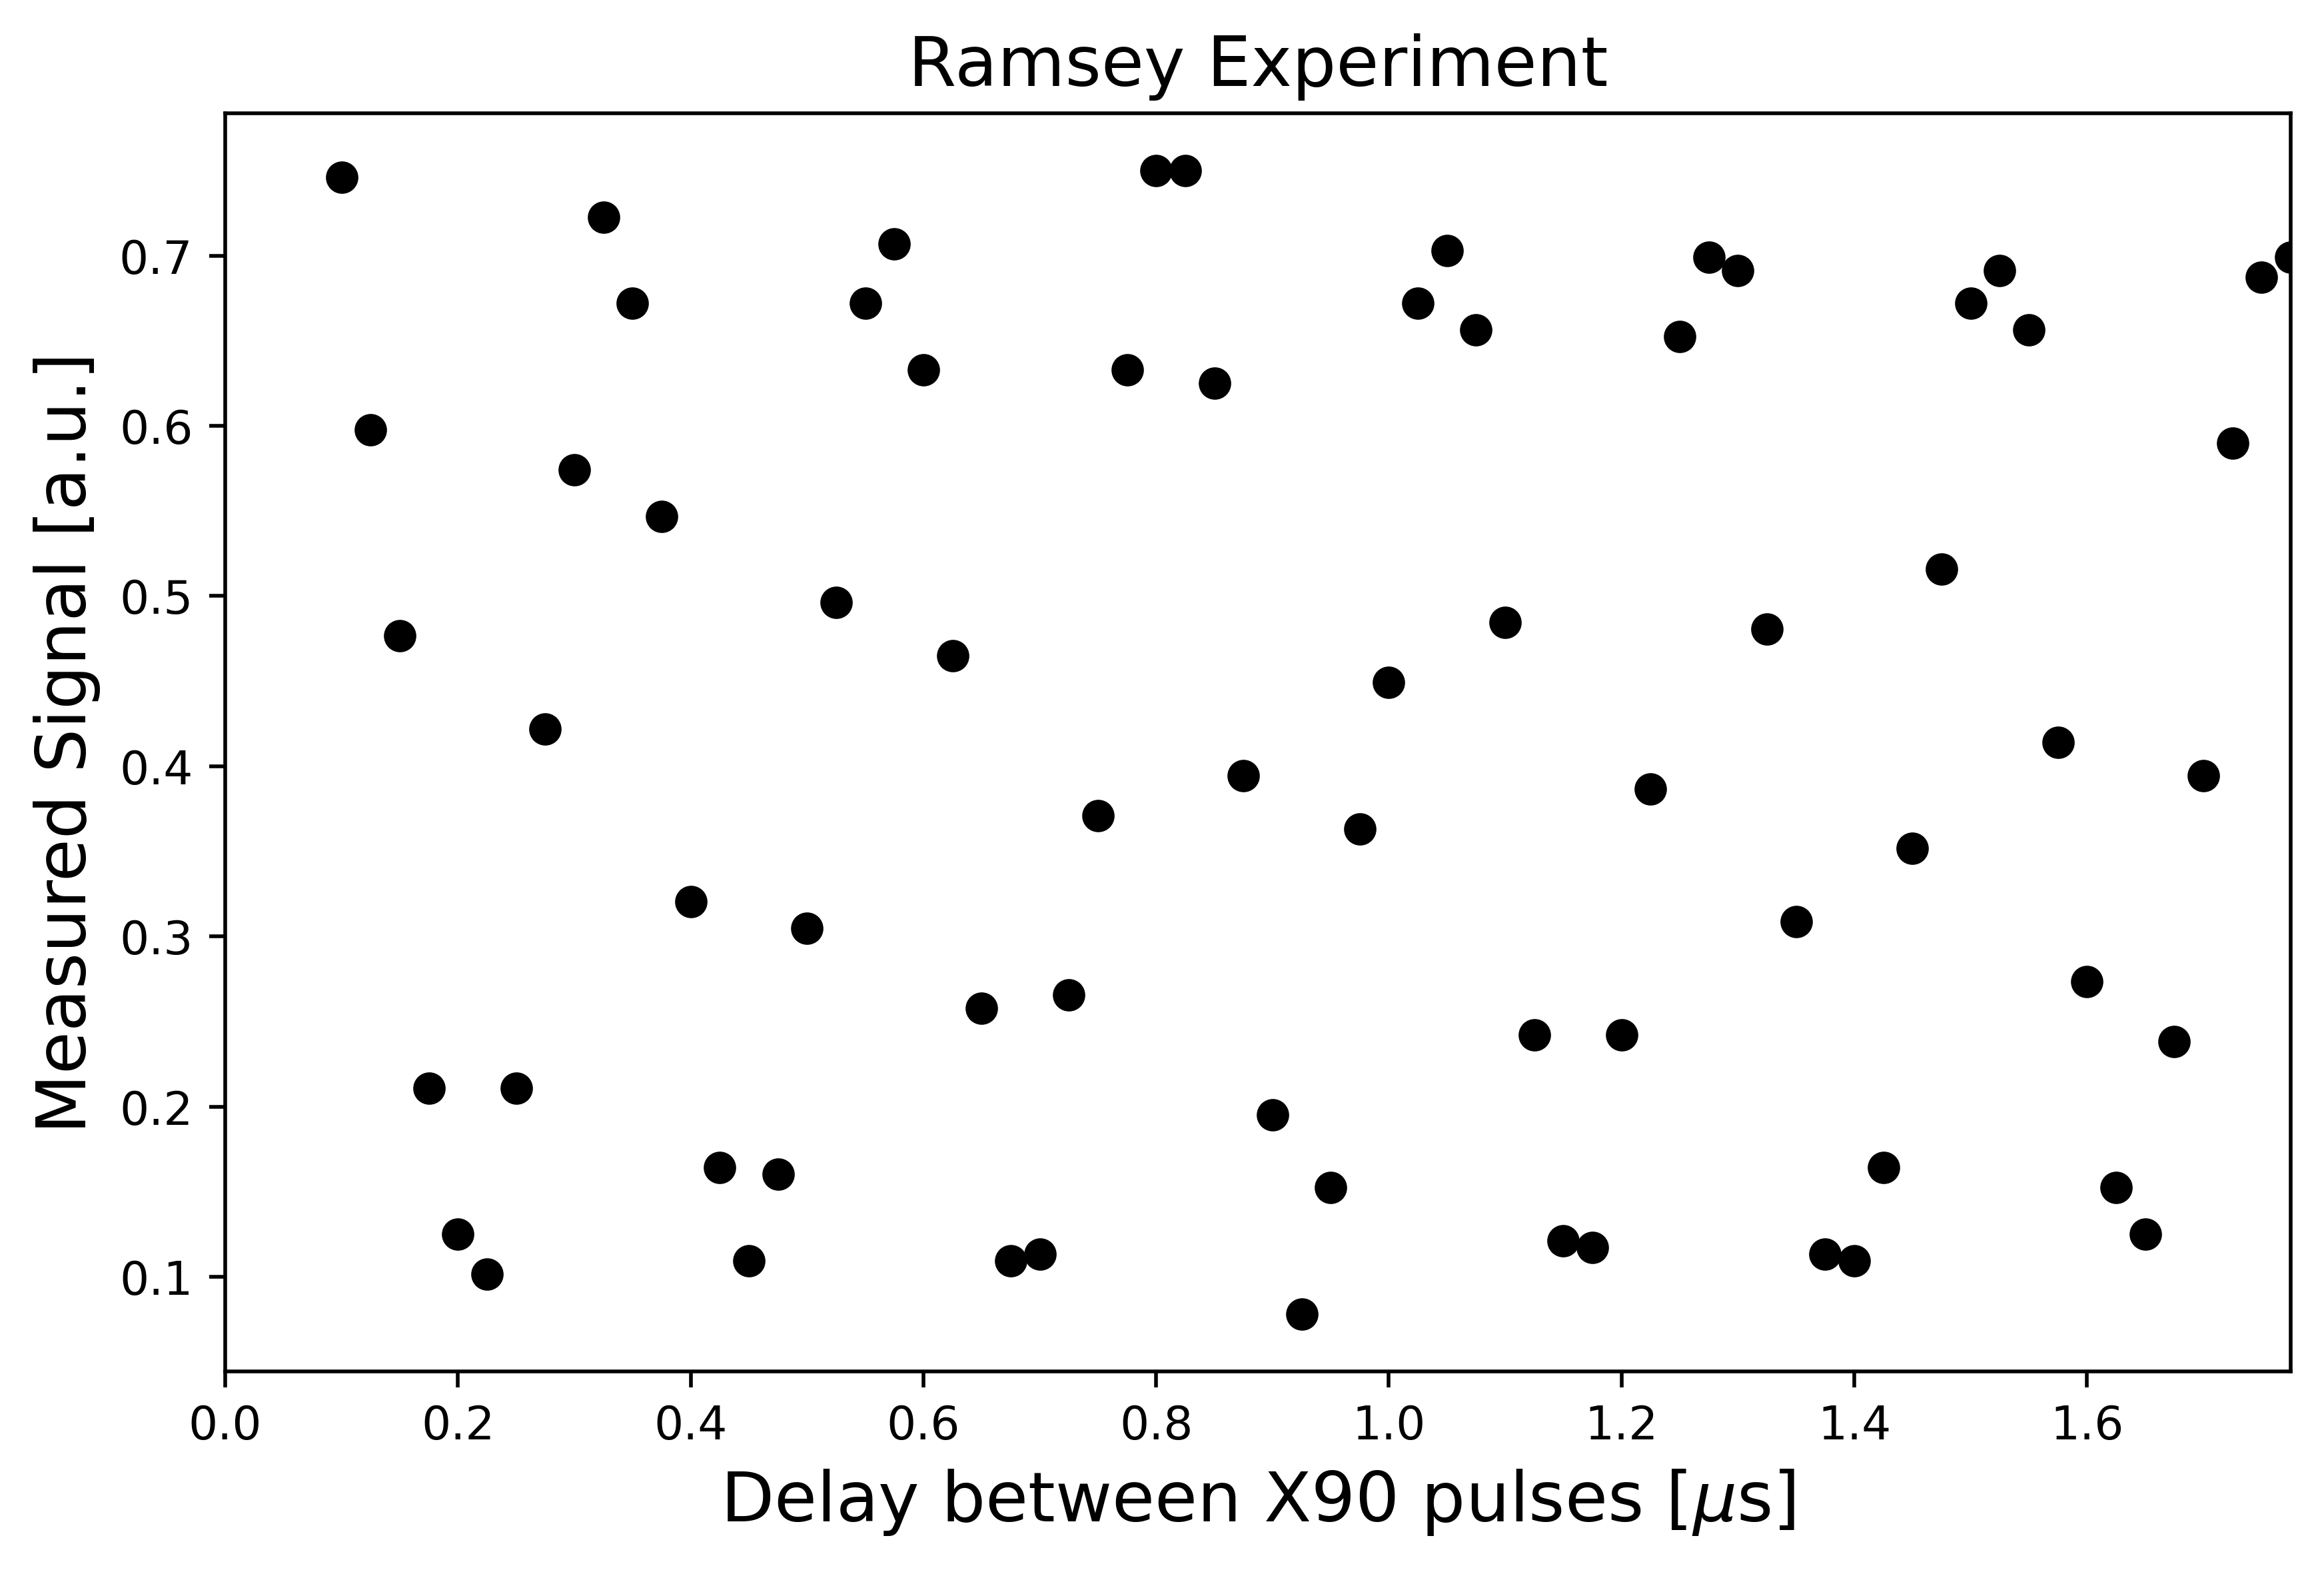

In [ ]:
ramsey_values = []

for i in range(len(delay_times_sec)):
    iq_data = ramsey_results.get_memory(i)[:,qubit] * scale_factor
    ramsey_values.append(sum(map(classify, iq_data)) / num_shots)

plt.figure(figsize=(8,5), dpi=500)    
plt.scatter(delay_times_sec/us, np.real(ramsey_values), color='black')
plt.xlim(0, np.max(delay_times_sec/us))
plt.title("Ramsey Experiment", fontsize=15)
plt.xlabel('Delay between X90 pulses [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.show()

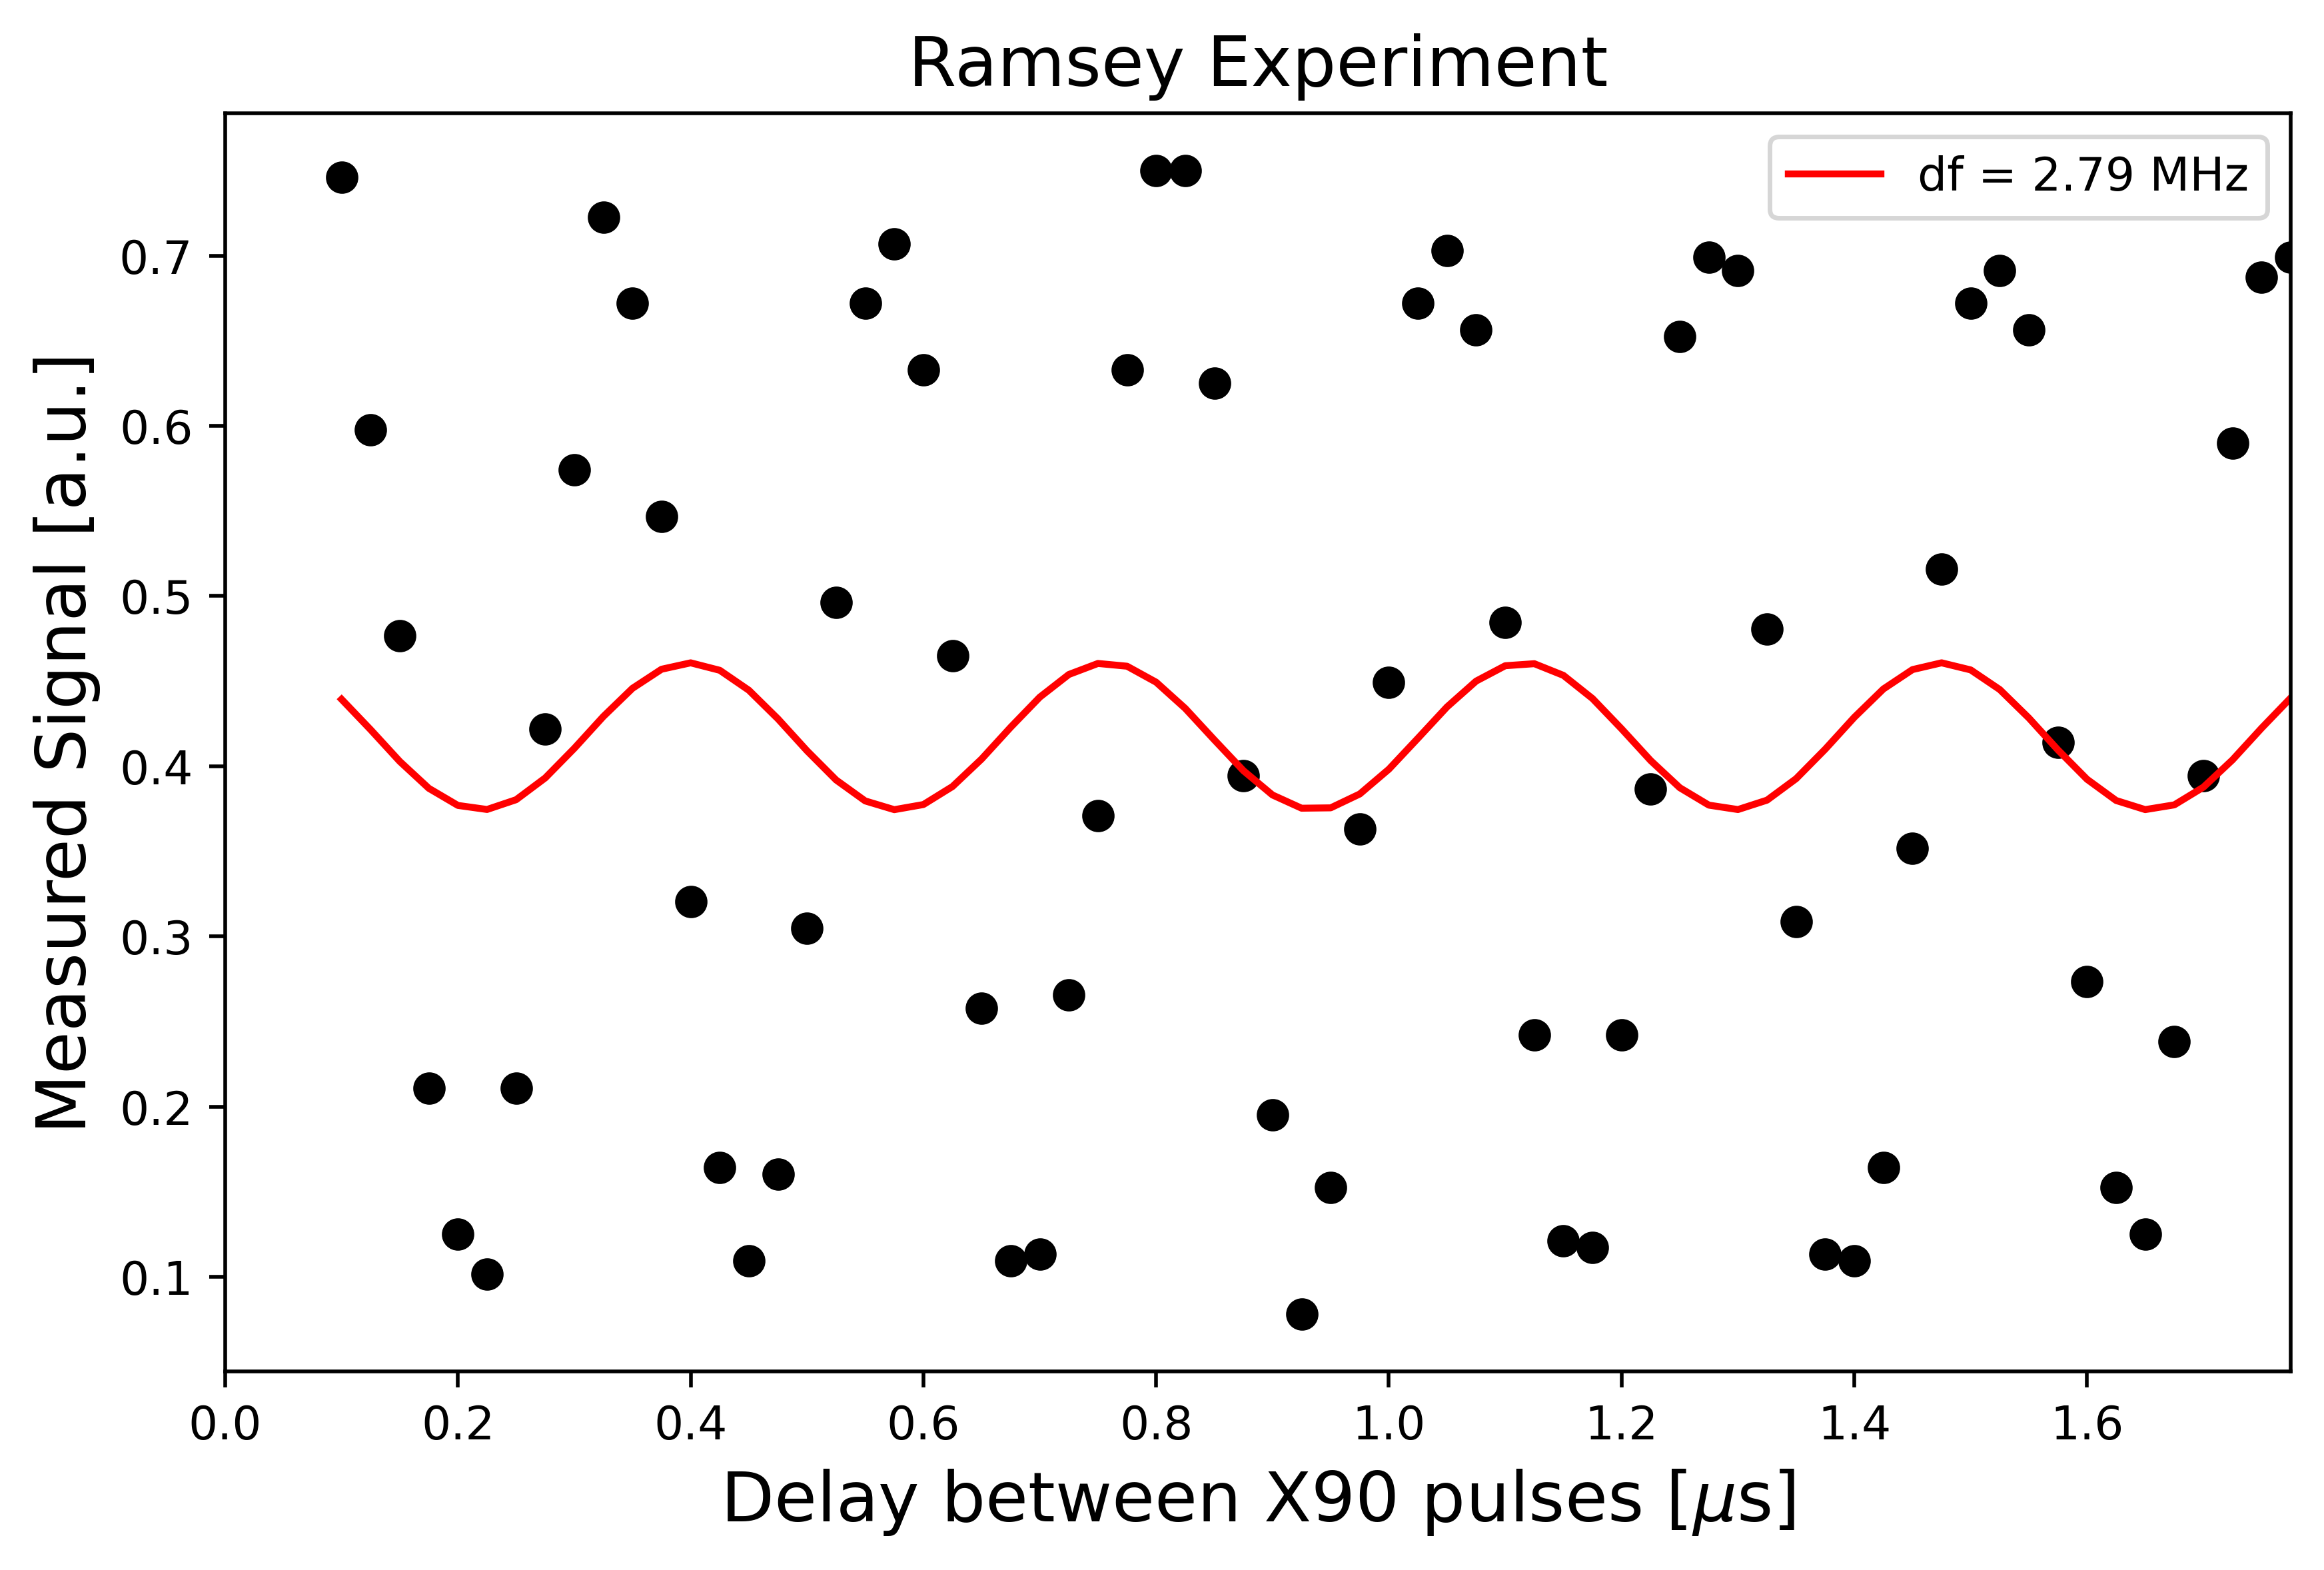

In [ ]:
fit_params, y_fit = fit_function(delay_times_sec/us, np.real(ramsey_values),
                                 lambda x, A, del_f_MHz, C, B: (
                                          A * np.cos(2*np.pi*del_f_MHz*x - C) + B
                                         ),
                                 [5, 1./0.4, 0, 0.25]
                                )

# Off-resonance component
_, del_f_MHz, _, _, = fit_params # freq is MHz since times in us

plt.figure(figsize=(8,5), dpi=500)
plt.scatter(delay_times_sec/us, np.real(ramsey_values), color='black')
plt.plot(delay_times_sec/us, y_fit, color='red', label=f"df = {del_f_MHz:.2f} MHz")
plt.xlim(0, np.max(delay_times_sec/us))
plt.xlabel('Delay between X90 pulses [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.title('Ramsey Experiment', fontsize=15)
plt.legend()
plt.show()

Qubit frequency estimation.

In [ ]:
precise_qubit_freq = rough_qubit_frequency + (detuning_MHz - del_f_MHz) * MHz # get new freq in Hz
print(f"Our updated qubit frequency is now {round(precise_qubit_freq/GHz, 6)} GHz. "
      f"It used to be {round(rough_qubit_frequency / GHz, 6)} GHz")

Our updated qubit frequency is now 5.156864 GHz. It used to be 5.157653 GHz


Hahn echo parameters.

In [ ]:
# T2 experiment parameters
tau_max_sec = 200 * us
tau_step_sec = 4 * us
delay_times_sec = np.arange(2 * us, tau_max_sec, tau_step_sec)

# We will use the pi_pulse and x90_pulse from previous experiments

In [ ]:
delay = Parameter('delay')
with pulse.build(backend=backend, default_alignment='sequential', name="T2 delay Experiment") as t2_schedule:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(precise_qubit_freq, drive_chan)
    pulse.call(x90_pulse)
    pulse.delay(delay, drive_chan)
    pulse.call(pi_pulse)
    pulse.delay(delay, drive_chan)
    pulse.call(x90_pulse)

In [ ]:
t2_gate = Gate("t2", 1, [delay])

qc_t2 = QuantumCircuit(1, 1)

qc_t2.append(t2_gate, [0])
qc_t2.measure(0, 0)
qc_t2.add_calibration(t2_gate, (0,), t2_schedule, [delay])

exp_t2_circs = [qc_t2.assign_parameters({delay: get_dt_from(d)}, inplace=False) for d in delay_times_sec]

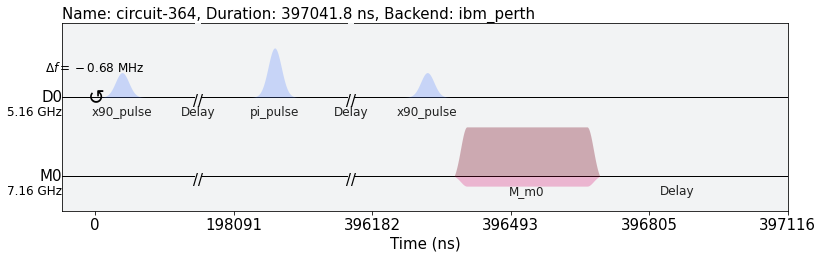

In [ ]:
t2_schedule = schedule(exp_t2_circs[-1], backend)
t2_schedule.draw(backend=backend)

In [ ]:
# Execution settings
num_shots_per_point = 512

job = backend.run(exp_t2_circs,
                  meas_level=1,
                  meas_return='single',
                  shots=num_shots_per_point)

job_monitor(job)

Job Status: job has successfully run


In [ ]:
t2_results = job.result(timeout=120)

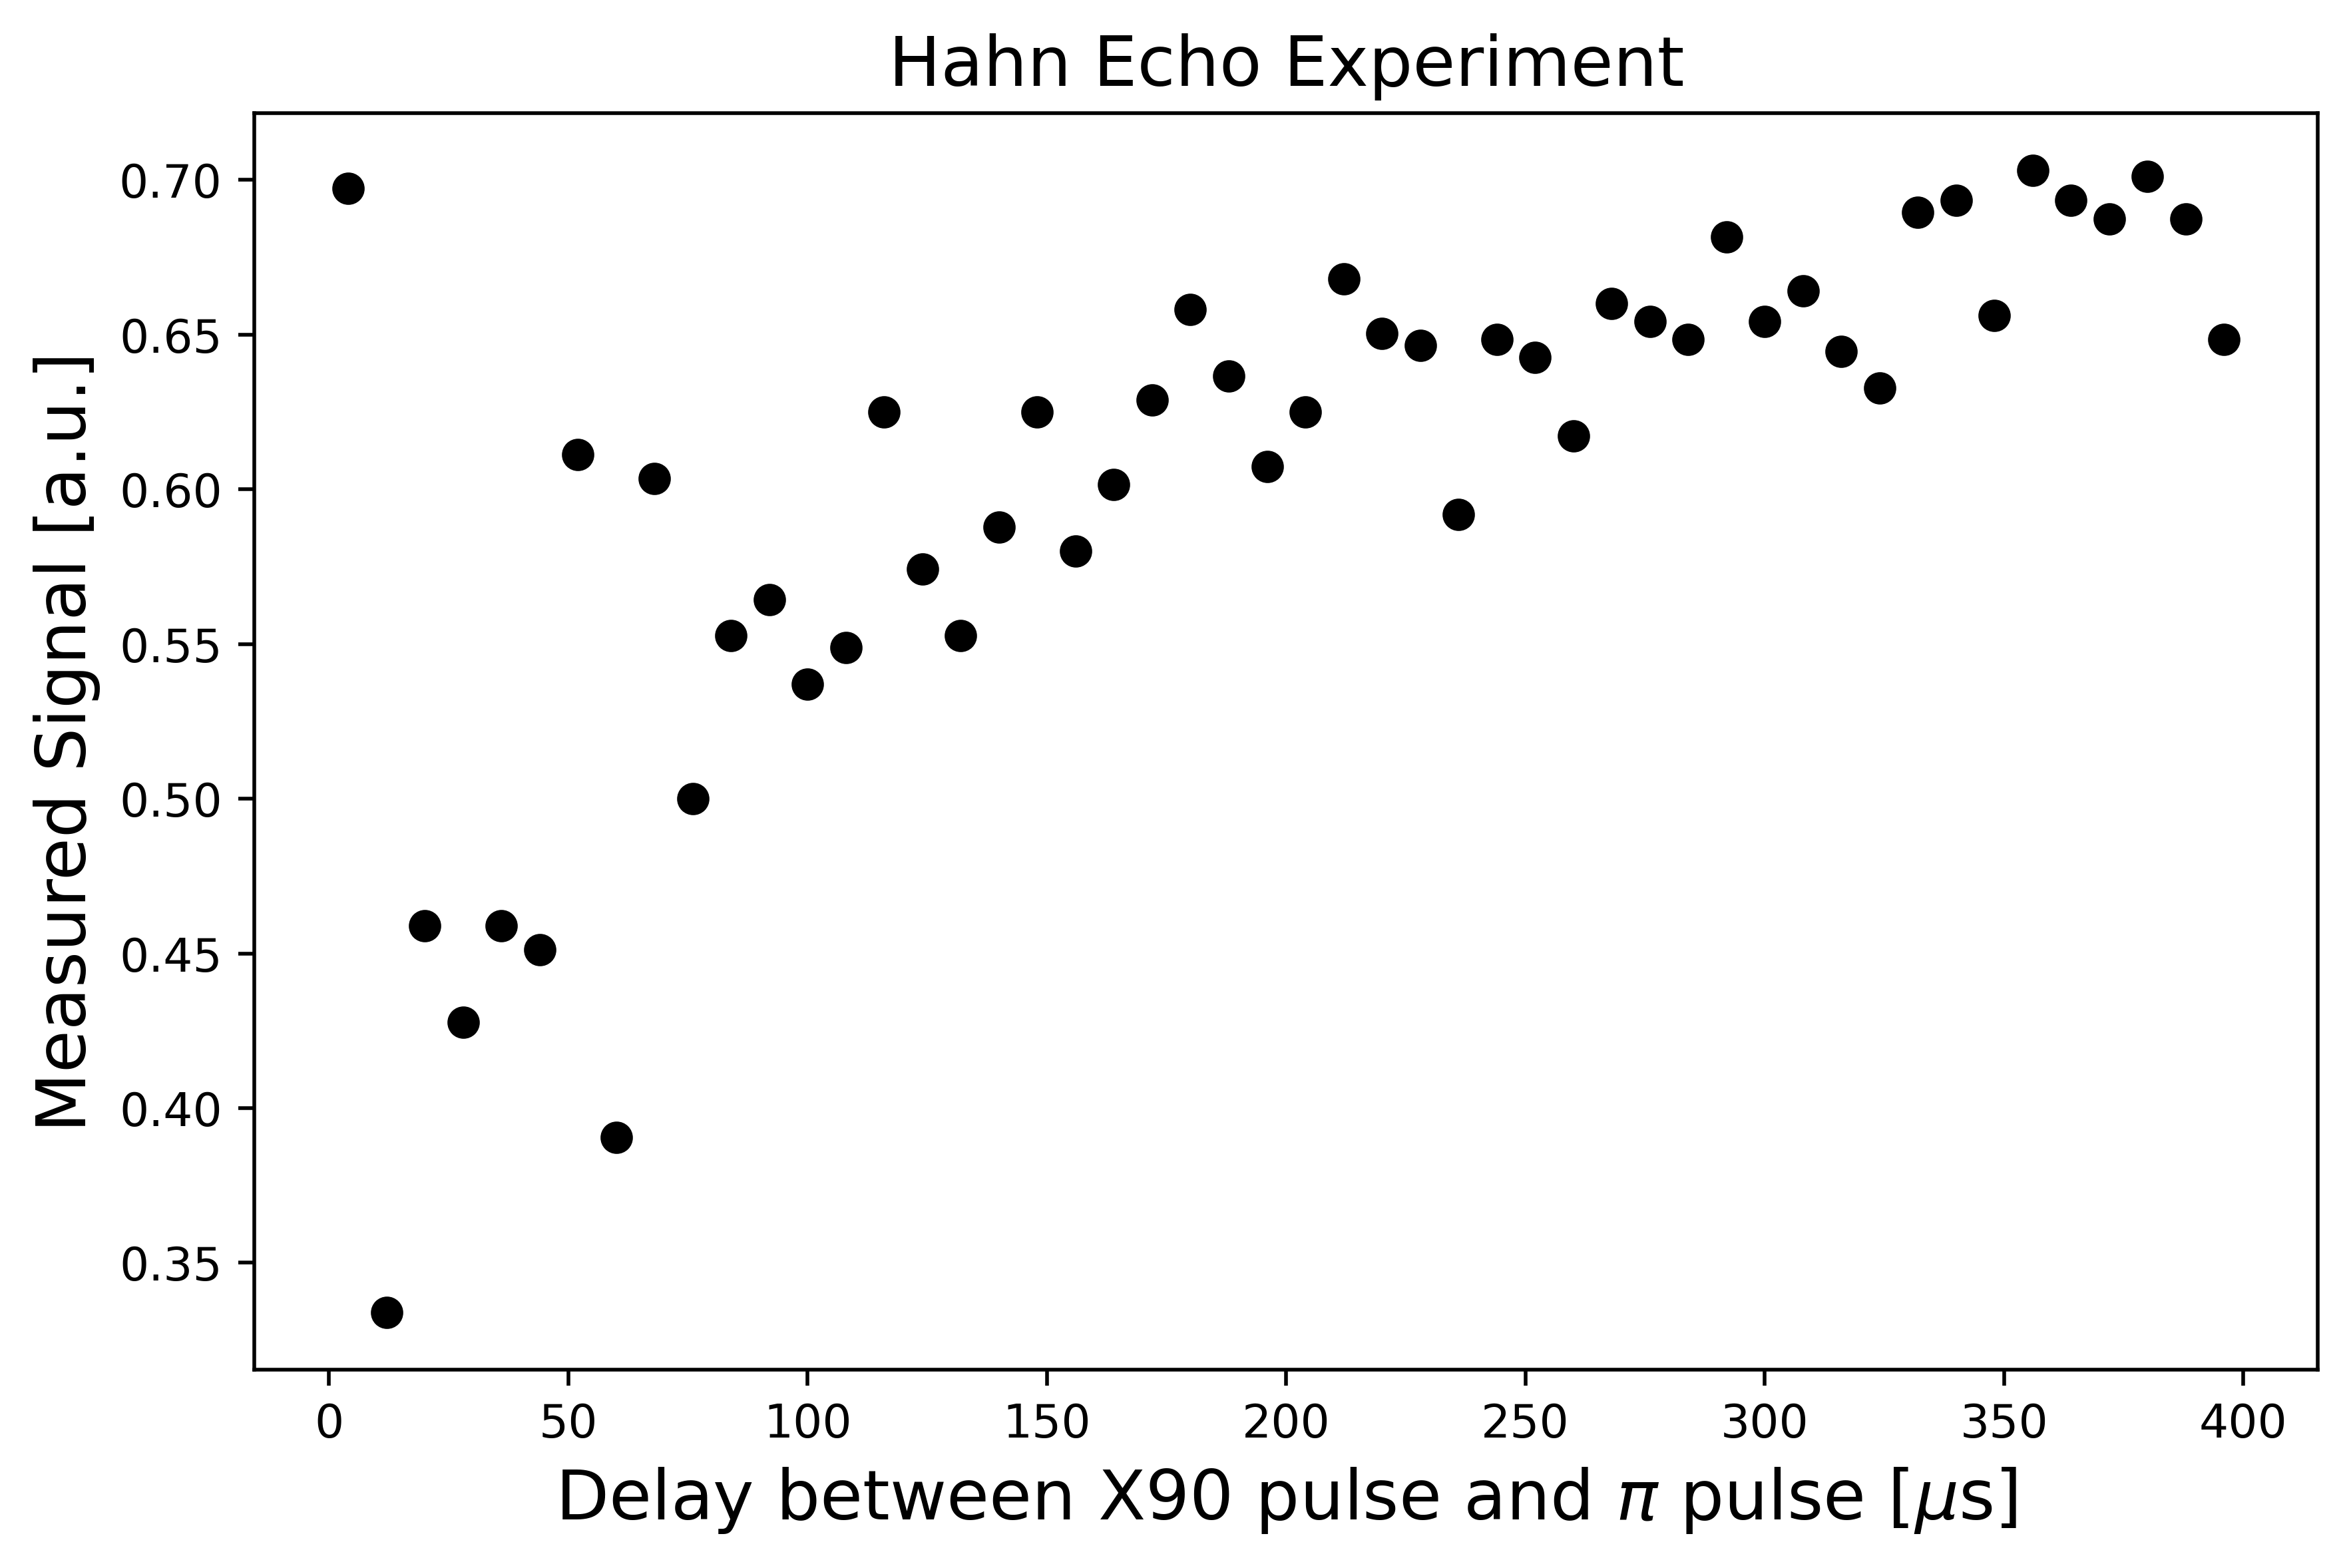

In [ ]:
t2_values = []

for i in range(len(delay_times_sec)):
    iq_data = t2_results.get_memory(i)[:,qubit] * scale_factor
    t2_values.append(sum(map(classify, iq_data)) / num_shots_per_point)

plt.figure(figsize=(8,5), dpi=500)
plt.scatter(2*delay_times_sec/us, t2_values, color='black')
plt.xlabel('Delay between X90 pulse and $\pi$ pulse [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.title('Hahn Echo Experiment', fontsize=15)
plt.show()

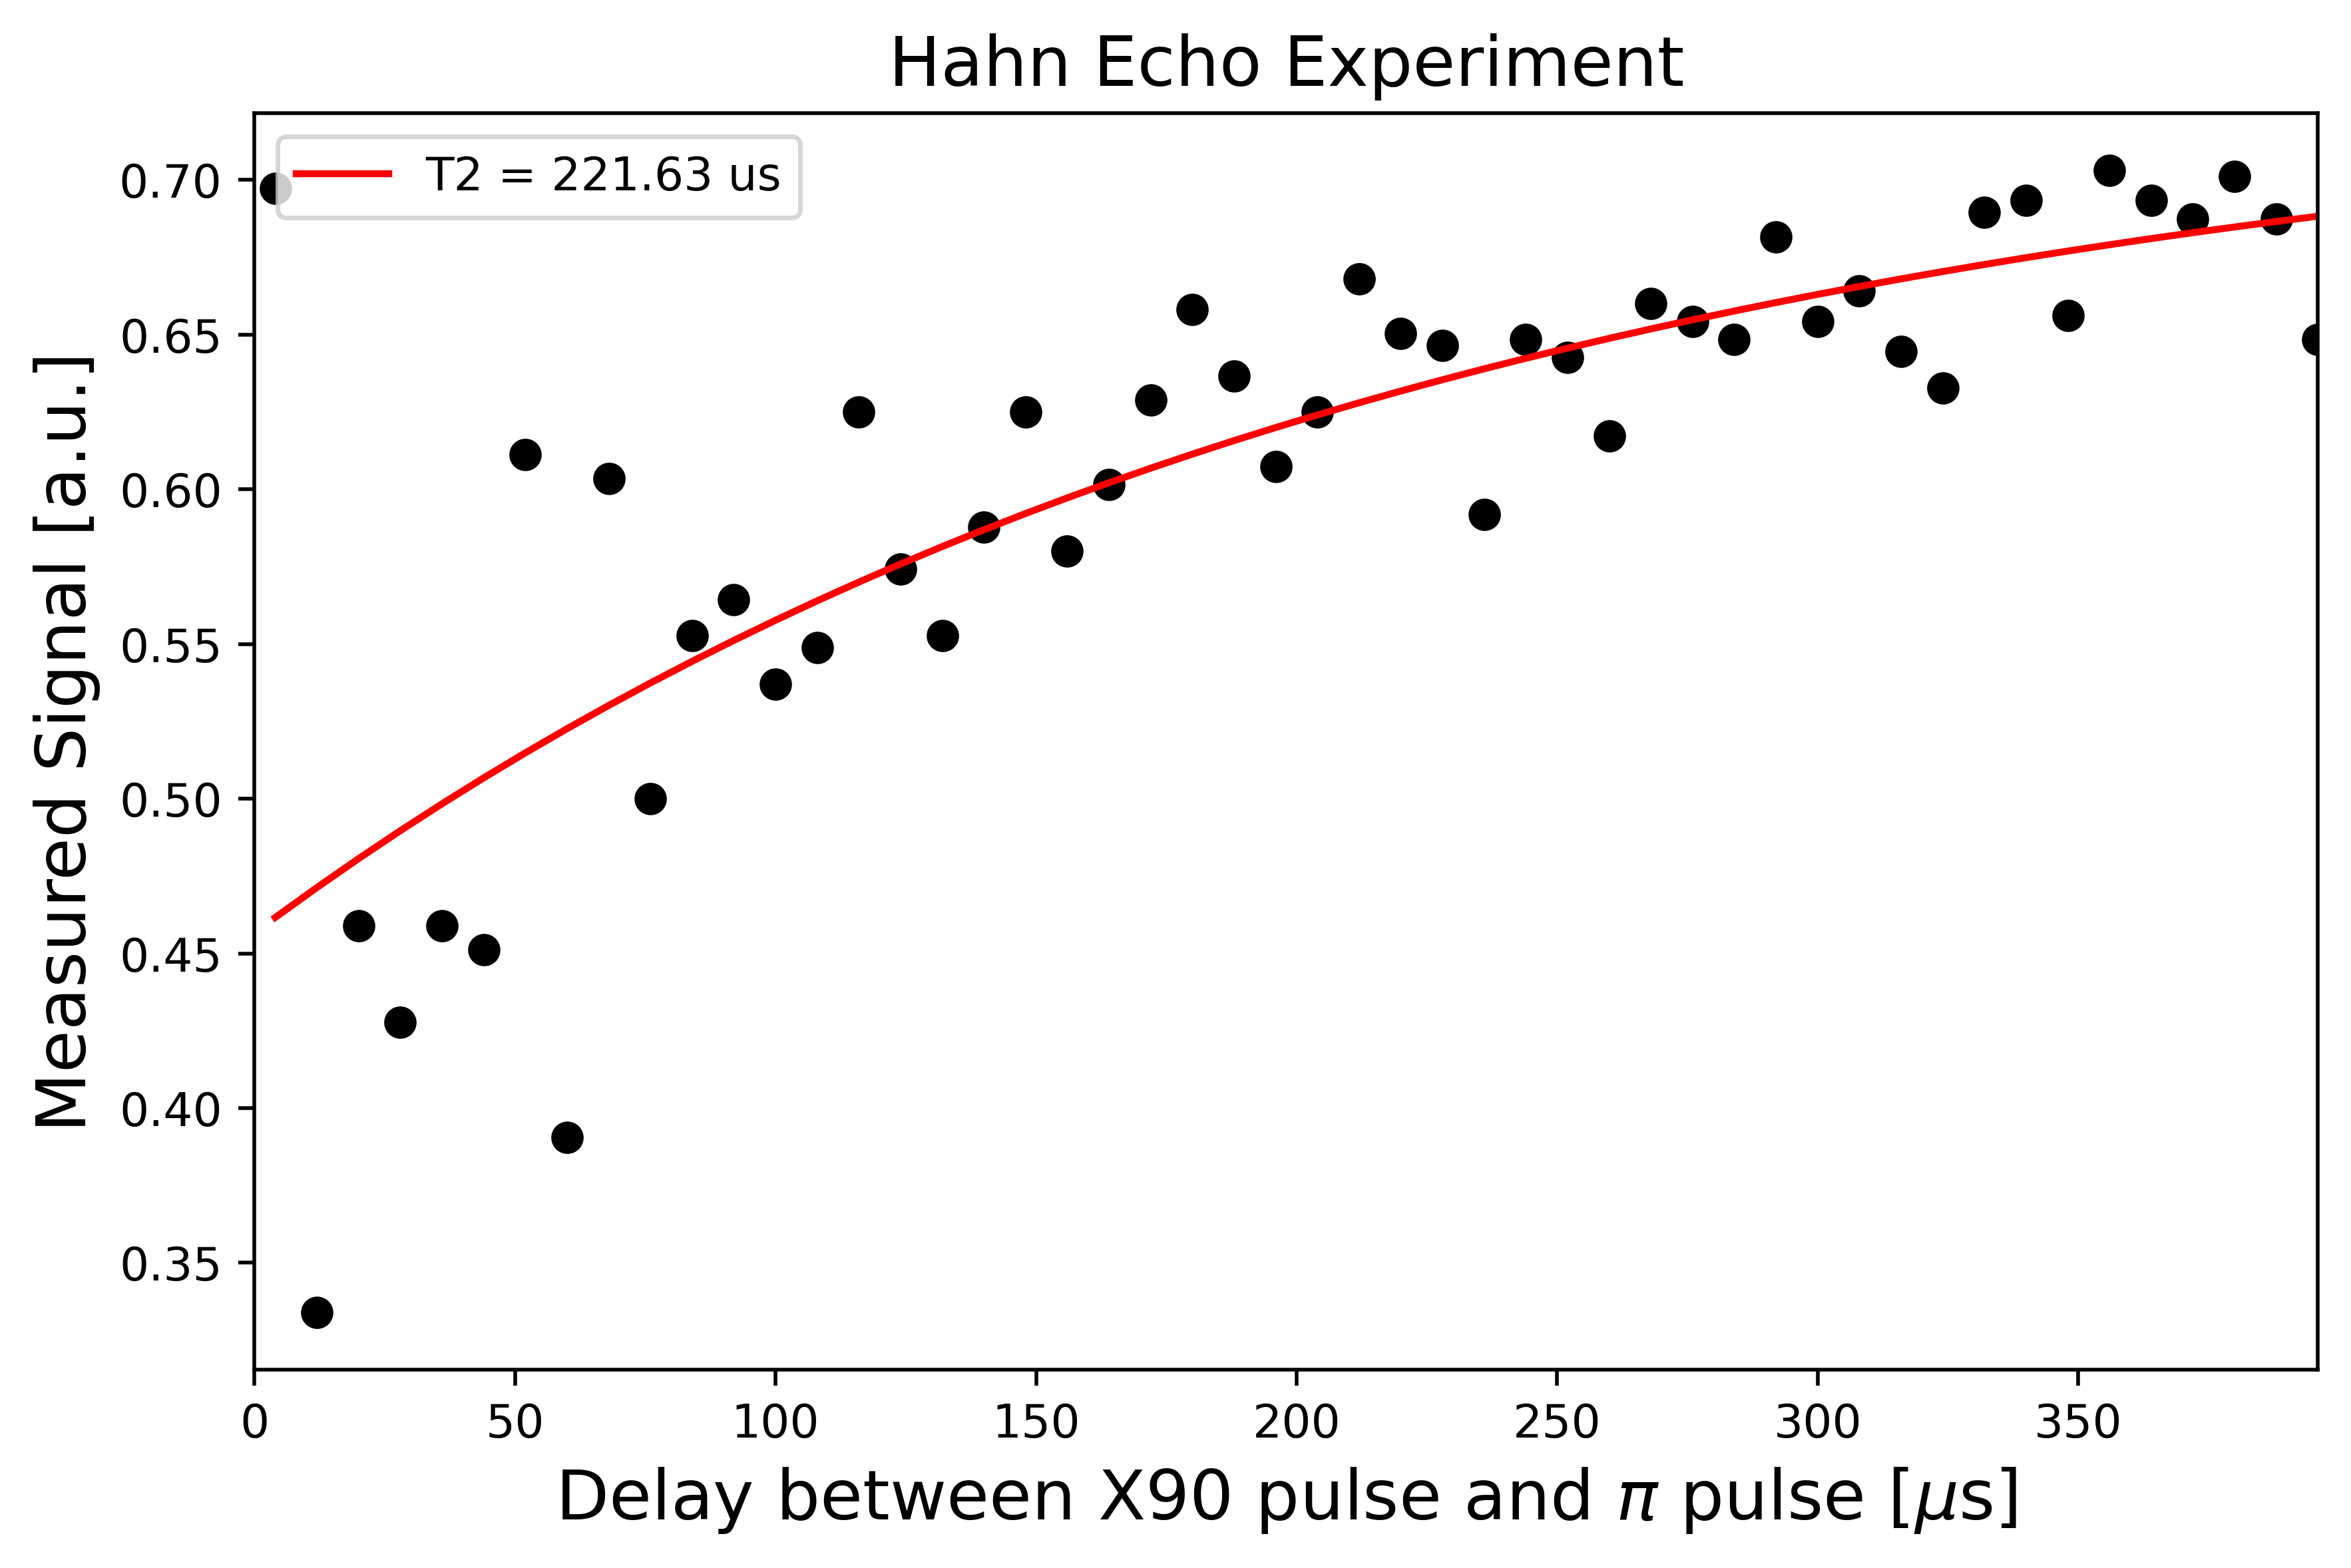

In [ ]:
fit_params, y_fit = fit_function(2*delay_times_sec/us, t2_values,
             lambda x, A, B, T2: (A * np.exp(-x / T2) + B),
             [-3, 0, 100])

_, _, T2 = fit_params
print()

plt.figure(figsize=(8,5), dpi=500)
plt.scatter(2*delay_times_sec/us, t2_values, color='black')
plt.plot(2*delay_times_sec/us, y_fit, color='red', label=f"T2 = {T2:.2f} us")
plt.xlim(0, np.max(2*delay_times_sec/us))
plt.xlabel('Delay between X90 pulse and $\pi$ pulse [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.title('Hahn Echo Experiment', fontsize=15)
plt.legend()
plt.show()

In [ ]:
# DD experiment parameters
tau_sec_min = 1 * us
tau_sec_max = 180 * us
tau_step_sec = 4 * us
taus_sec = np.arange(tau_sec_min, tau_sec_max, tau_step_sec)

num_sequence = 1 # apply 1 sequence
print(f"Total time ranges from {2.*num_sequence*taus_sec[0] / us} to {2.*num_sequence*taus_sec[-1] / us} us")

Total time ranges from 2.0 to 354.0 us


In [ ]:
delay = Parameter('delay')
with pulse.build(backend=backend, default_alignment='sequential', name="T2DD delay Experiment") as T2DD_schedule:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(precise_qubit_freq, drive_chan)
    pulse.call(x90_pulse)
    pulse.delay(delay/2, drive_chan)
    for loop_counts in range(num_sequence):
        pulse.call(pi_pulse)
        pulse.delay(delay, drive_chan)
        with pulse.phase_offset(np.pi/2, pulse.drive_channel(qubit)):
            pulse.call(pi_pulse)
        pulse.delay(delay, drive_chan)
        pulse.call(pi_pulse)
        pulse.delay(delay, drive_chan)
        with pulse.phase_offset(np.pi/2, pulse.drive_channel(qubit)):
            pulse.call(pi_pulse)
        if loop_counts != num_sequence-1:
            pulse.delay(delay, drive_chan)
    pulse.delay(delay/2, drive_chan)
    pulse.call(x90_pulse)

In [ ]:
T2DD_gate = Gate("T2DD", 1, [delay])

qc_T2DD = QuantumCircuit(1, 1)

qc_T2DD.append(T2DD_gate, [0])
qc_T2DD.measure(0, 0)
qc_T2DD.add_calibration(T2DD_gate, (0,), T2DD_schedule, [delay])

exp_T2DD_circs = [qc_T2DD.assign_parameters({delay: get_dt_from(d)}, inplace=False) for d in taus_sec]

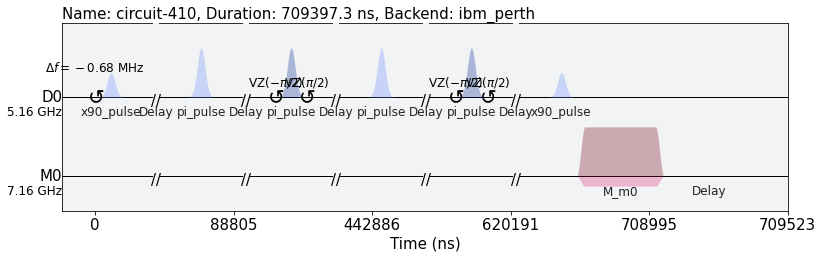

In [ ]:
T2DD_schedule = schedule(exp_T2DD_circs[-1], backend)
T2DD_schedule.draw(backend=backend)

In [ ]:
num_shots_per_point = 1024

job = backend.run(exp_T2DD_circs,
                  meas_level=1,
                  meas_return='single',
                  shots=num_shots_per_point)


job_monitor(job)

Job Status: job incurred error    


In [ ]:
T2DD_results = job.result(timeout=120)

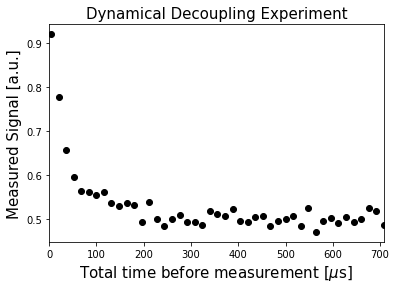

In [ ]:
times_sec = 4*num_sequence*taus_sec
DD_values = []

for i in range(len(times_sec)):
    iq_data = T2DD_results.get_memory(i)[:,qubit] * scale_factor
    DD_values.append(sum(map(classify, iq_data)) / num_shots_per_point)

plt.scatter(times_sec/us, DD_values, color='black')
plt.xlim(0, np.max(times_sec/us))
plt.xlabel('Total time before measurement [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.title('Dynamical Decoupling Experiment', fontsize=15)
plt.show()

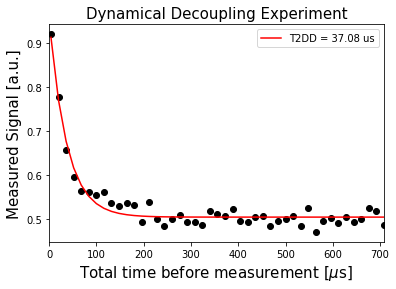

In [ ]:
# Fit the data
fit_func = lambda x, A, B, T2DD: (A * np.exp(-x / T2DD) + B)
fitparams, conv = curve_fit(fit_func, times_sec/us, DD_values, [3.5, 0.8, 150])

_, _, T2DD = fitparams
plt.scatter(times_sec/us, DD_values, color='black')
plt.plot(times_sec/us, fit_func(times_sec/us, *fitparams), color='red', label=f"T2DD = {T2DD:.2f} us")
plt.xlim([0, np.max(times_sec/us)])
plt.xlabel('Total time before measurement [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.title('Dynamical Decoupling Experiment', fontsize=15)
plt.legend()
plt.show()

## 5. References <a id="refs"></a>

1. H. Abraham, I. Y. Akhalwaya, G. Aleksandrowicz, T. Alexander, G. Alexandrowics, E. Arbel, A. Asfaw, C. Azaustre, P. Barkoutsos, G. Barron, L. Bello, Y. Ben-Haim, L. S. Bishop, S. Bosch, D. Bucher, CZ, F. Cabrera, P. Calpin, L. Capelluto, J. Carballo, C.-F. Chen, A. Chen, R. Chen, J. M. Chow, C. Claus, A. W. Cross, A. J. Cross, J. Cruz- Benito, C. Culver, A. D. C ́orcoles-Gonzales, S. Dague, M. Dartiailh, A. R. Davila, D. Ding, E. Dumitrescu, K. Dumon, I. Duran, P. Eendebak, D. Egger, M. Everitt, P. M. Fern ́andez, A. Frisch, A. Fuhrer, J. Gacon, Gadi, B. G. Gago, J. M. Gambetta, L. Garcia, S. Garion, Gawel-Kus, L. Gil, J. Gomez-Mosquera, S. de la Puente Gonz ́alez, D. Green- berg,J.A.Gunnels,I.Haide,I.Hamamura,V.Havlicek,J.Hellmers,L􏰀.Herok,H.Horii, C. Howington, W. Hu, S. Hu, H. Imai, T. Imamichi, R. Iten, T. Itoko, A. Javadi-Abhari, Jessica, K. Johns, N. Kanazawa, A. Karazeev, P. Kassebaum, V. Krishnan, K. Kr- sulich, G. Kus, R. LaRose, R. Lambert, J. Latone, S. Lawrence, P. Liu, P. B. Z. Mac, Y. Maeng, A. Malyshev, J. Marecek, M. Marques, D. Mathews, A. Matsuo, D. T. Mc- Clure, C. McGarry, D. McKay, S. Meesala, A. Mezzacapo, R. Midha, Z. Minev, P. Mu- rali, J. Mu ̈ggenburg, D. Nadlinger, G. Nannicini, P. Nation, Y. Naveh, Nick-Singstock, P. Niroula, H. Norlen, L. J. O’Riordan, S. Oud, D. Padilha, H. Paik, S. Perriello, A. Phan, M. Pistoia, A. Pozas-iKerstjens, V. Prutyanov, J. P ́erez, Quintiii, R. Raymond, R. M.-C. Redondo, M. Reuter, D. M. Rodr ́ıguez, M. Ryu, M. Sandberg, N. Sathaye, B. Schmitt, C. Schnabel, T. L. Scholten, E. Schoute, I. F. Sertage, Y. Shi, A. Silva, Y. Siraichi, S. Sivarajah, J. A. Smolin, M. Soeken, D. Steenken, M. Stypulkoski, H. Takahashi, C. Taylor, P. Taylour, S. Thomas, M. Tillet, M. Tod, E. de la Torre, K. Trabing, M. Treinish, TrishaPe, W. Turner, Y. Vaknin, C. R. Valcarce, F. Varchon, D. Vogt- Lee, C. Vuillot, J. Weaver, R. Wieczorek, J. A. Wildstrom, R. Wille, E. Winston, J. J. Woehr, S. Woerner, R. Woo, C. J. Wood, R. Wood, S. Wood, J. Wootton, D. Yeralin, J. Yu, L. Zdanski, Zoufalc, azulehner, drholmie, fanizzamarco, kanejess, klinvill, merav aharoni, ordmoj, tigerjack, yang.luh, and yotamvakninibm, “Qiskit: An open-source framework for quantum computing,” 2019.
2. D. C. McKay, T. Alexander, L. Bello, M. J. Biercuk, L. Bishop, J. Chen, J. M. Chow, A. D. C ́orcoles, D. Egger, S. Filipp, J. Gomez, M. Hush, A. Javadi-Abhari, D. Moreda, P. Nation, B. Paulovicks, E. Winston, C. J. Wood, J. Wootton, and J. M. Gambetta, “Qiskit backend specifications for OpenQASM and OpenPulse experiments,” 2018.

**Note:** 'Qiskit Pulse' was formerly known as 'OpenPulse'.

In [ ]:
import qiskit.tools.jupyter
%qiskit_version_table